# Car Price Prediction


**Цель проекта:** Необходимо прогнозировать стоимость автомобилей на вторичном рынке по их характеристикам.

- Нам дан тестовый набор данных с сайта auto.ru. 
- Критерий оценки MAPI.
- Данные для обучения необходимо получить самостоятельно.
- Задача осложняется тем, что проверка результатов будет осуществляться на основе цен исходных данных тестового датасета 2020 года, а сейчас 2022 год. Поэтому придется дополнительно корректировать цены.


In [210]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import json
# import selenium
import pickle
import time
from datetime import datetime
# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, accuracy_score, mean_absolute_percentage_error
# from sklearn.collections import counter
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import scipy.sparse

In [211]:
# from selenium import webdriver
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from webdriver_manager.chrome import ChromeDriverManager
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

from pymystem3 import Mystem
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [213]:
path = 'C:/Users/User/dict_proj/'
sub = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

## Parsing

Данные об автомобилях будем получать самостоятельно парсингом сайта auto.ru.

Для парсинга изначально использовалась библиотека **requests**, однако полученные с ее помощью данные не соответствовали данным с сайта (подставляются другие значения, видимо, это защита от парсинга). Проблему удалось решить с помощью библиотеки **selenium**. При этом парсинг ведется через окно браузера и намного медленнее.

In [214]:
# Нас интересуют бренды, имеющиеся в тестовых данных.
all_brands = []
for i in test.brand.unique().tolist():
    all_brands.append(i.lower())

Ниже предоставлены функции с помощью которых производился парсинг.

In [215]:
# service = Service(executable_path=ChromeDriverManager().install())
# options = Options()
# driver = webdriver.Chrome(service=service)#, options=options)
# # driver.get('https://auto.ru/')
# def document_initialised(driver):
#     return driver.execute_script("return initialised")

In [216]:
host = 'https://auto.ru/'
# url = 'https://auto.ru/cars/toyota/used/'

# В куки необходимо передать "согласие с условиями", иначе сайт перенаправляет на другую страницу.
cookies = {
    'mindboxDeviceUUID': '9660a218-f6e5-4ff3-a332-107a17540545',
    'autoru_gdpr': '1',
}
headers = {
    'Accept':
    'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'User-Agent':
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36'
}


def all_brand_url(brand_list):
    ''' Находим все поисковые страницы для брендов.'''
    all_brand_url_list = []
    for brand in brand_list:
        url = 'https://auto.ru/cars/' + brand + '/used/'
        all_brand_url_list.append(url)
    return all_brand_url_list


def get_html(url, params={}):
    ''' html поисковых страниц.'''
    url1 = url + '?' + '&'.join([k + '=' + str(v) for k, v in params.items()
                                 ]) if params else url
    driver.get(url1)
    try:
        value = driver.find_element(By.ID, 'confirm-button').is_enabled()
        if value:
            driver.find_element(By.ID, 'confirm-button').click()
    except:
        pass
    WebDriverWait(driver, 10).until(
        lambda d: d.find_element_by_class_name("ListingCars__loaderOverlay"))
    time.sleep(np.random.randint(1, 3))
    a = driver.page_source
    #     r = requests.get(url, headers = headers, params = params, cookies = cookies)
    #     r.encoding = 'utf-8'
    return a


def get_car_url(html):
    '''Находим ссылки на каждую машину на странице.'''
    soup = BeautifulSoup(html, 'html.parser')
    items = soup.find_all('div', class_='ListingItem')
    car_url = []

    for item in items:
        car_url.append(
            item.find('div', class_='ListingItem__main').find(
                'div', class_='ListingItem__description').find(
                    'div',
                    class_='ListingItem__column ListingItem__column_left').
            find('div', class_='ListingItem__columnRowFlex').find(
                'div', class_='ListingItem__columnCellSummary').find(
                    'h3', class_='ListingItemTitle ListingItem__title').find(
                        'a').get('href'))
    return car_url


def get_npages(html):
    '''Находим кол-во имеюцихся поисковых страниц по каждому бренду.'''
    s = BeautifulSoup(html, 'html.parser')
    page_list = []
    pages = s.find_all(
        'a',
        class_=
        'Button Button_color_whiteHoverBlue Button_size_s Button_type_link Button_width_default ListingPagination__page'
    )
    page = pages[-1].find('span', class_='Button__text').get_text()
    return int(page)


def parsing_for_all_url():
    '''По всем поисковым страницам получаем все урл автомобилей.'''
    all_url_list = []
    n_page = 0
    for url in all_brand_url(all_brands):
        print(url)
        html = get_html(url)
        #         print(html.status_code)
        npages = get_npages(html)
        print(npages)
        for page in range(1, npages + 1):
            n_page += 1
            if n_page % 10 == 0:
                print('Парсим страницу - ', n_page, all_url_list[-1])
            if page > 1:
                html = get_html(url, params={'page': page})

            all_url_list += get_car_url(html)

    return all_url_list


def get_obj(file_path):
    '''Функция для загрузки файла с диска.'''
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except:
        return None


def save_obj(mobj, file_path):
    '''Функция для сохранения файла на диск.'''
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(mobj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except:
        pass

In [217]:
def parsing(list_of_url):
    ''' Находим все нужные нам данные со страниц автомобилей и сохраняем в один большой словарь.
        Предусмотрено сохранение данных на диск и продолжение работы после остановок и сбоев.
    '''
    big_dict = get_obj(path + 'big_dict_project/' + 'big_dict.pkl')
    counter = len(big_dict)
    for url in list_of_url:
        #         print(url)

        h_url = hash(url)
        if h_url in big_dict:
            if len(big_dict[h_url]) > 2:
                continue
        big_dict[h_url] = {'url': url}

        driver.get(url)
        try:
            value = driver.find_element(By.ID, 'confirm-button').is_enabled()
            if value:
                driver.find_element(By.ID, 'confirm-button').click()
        except:
            pass

        try:
            WebDriverWait(
                driver,
                10).until(lambda d: d.find_element_by_id("initial-state"))
            a = driver.page_source.encode(encoding='utf-8')
            t_dict = {}
            s = BeautifulSoup(a, 'html.parser')
            s.decode()
            pattern = re.compile('CardInfoRow (\S+)')
            p = re.compile(
                '"delivery_info":{.*},"description":"(.+?)","discount_options":'
            )
            a1 = s.find('script', id="initial-state").contents[0]
            a1 = unicodedata.normalize('NFC', a1)
            a2 = a1.replace('true', '1').replace('false', '0').replace('\n', '').replace('none', '0')\
                                     .replace("\"'", '"').replace("'\"", '"')
            json_acceptable_string = a2
            d = json.loads(json_acceptable_string)
            dc = d['card']
            save_obj(dc, path + 'h' + str(h_url) + '.pkl')
        except:
            print('ouch')
            continue

        if 'vehicle_info' in dc:
            for k in [
                    'super_gen', 'equipment', 'model_info', 'configuration',
                    'complectation', 'tech_param', 'vendor', 'mark_info'
            ]:
                if k in dc['vehicle_info']:
                    if k == 'mark_info':
                        t_dict['brand'] = dc['vehicle_info']['mark_info'][
                            'name']
                    elif k == 'model_info':
                        t_dict['model_name'] = dc['vehicle_info'][
                            'model_info']['name']
                        t_dict[k] = dc['vehicle_info'][k]
                    elif k == 'configuration':
                        if 'doors_count' in dc['vehicle_info'][
                                'configuration']:
                            t_dict['number_of_doors'] = dc['vehicle_info'][
                                'configuration']['doors_count']
                        if 'body_type' in dc['vehicle_info']['configuration']:
                            t_dict['vehicle_configuration'] = dc[
                                'vehicle_info']['configuration']['body_type']
                    elif k == 'tech_param':
                        if 'human_name' in dc['vehicle_info']['tech_param']:
                            t_dict['human_name'] = dc['vehicle_info'][
                                'tech_param']['human_name']
                        if 'transmission' in dc['vehicle_info']['tech_param']:
                            t_dict['transmission'] = dc['vehicle_info'][
                                'tech_param']['transmission']
                    elif k == 'complectation':
                        t_dict['complectation'] = dc['vehicle_info'][
                            'complectation']
                        if 'vendor_colors' in dc['vehicle_info'][
                                'complectation']:
                            del (t_dict['complectation']['vendor_colors'])

                    else:
                        t_dict[k] = dc['vehicle_info'][k]

        if 'price_info' in dc:
            if 'price' in dc['price_info']:
                t_dict['price'] = dc['price_info']['price']
            if 'currency' in dc['price_info']:
                t_dict['currency'] = dc['price_info']['currency']
        if 'market_price' in dc:
            if 'price' in dc['market_price']:
                t_dict['market_price'] = dc['market_price']['price']
            if 'currency' in dc['market_price']:
                t_dict['market_currency'] = dc['market_price']['currency']
        if 'description' in dc:
            t_dict['description'] = dc['description']
        t_dict['url'] = url
        table_items = s.find_all('li', class_=pattern)
        for item in table_items:
            t_dict[item.find('span').get_text()] = item.find_all(
                'span')[-1].get_text()
        big_dict[h_url] = t_dict
        counter += 1
        if counter % 100 == 0:
            print('--- ', counter)
            save_obj(big_dict, path + 'big_dict_project/' + 'big_dict.pkl')
        if url == list_of_url[-1]:
            save_obj(big_dict, path + 'big_dict_project/' + 'big_dict.pkl')
    return big_dict

Препроцессинг будет проводиться одновременно на всех данных (тренировочных и тестовых). Для этого данные парсинга будут преобразованы к тому же виду, что тест, и объединены (с добавлением колонки-индикатора sample).

In [218]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [219]:
test.columns = [
    'body_type', 'brand', 'car_url', 'color', 'complectation_dict',
    'description', 'engine_displacement', 'engine_power', 'equipment_dict',
    'fuel_type', 'image', 'mileage', 'model_date', 'model_info', 'model_name',
    'name', 'number_of_doors', 'parsing_unixtime', 'price_currency',
    'production_date', 'sell_id', 'super_gen', 'vehicle_configuration',
    'vehicle_transmission', 'vendor', 'owners', 'владение', 'ПТС', 'привод',
    'руль', 'состояние', 'таможня'
]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   body_type              34686 non-null  object
 1   brand                  34686 non-null  object
 2   car_url                34686 non-null  object
 3   color                  34686 non-null  object
 4   complectation_dict     6418 non-null   object
 5   description            34686 non-null  object
 6   engine_displacement    34686 non-null  object
 7   engine_power           34686 non-null  object
 8   equipment_dict         24690 non-null  object
 9   fuel_type              34686 non-null  object
 10  image                  34686 non-null  object
 11  mileage                34686 non-null  int64 
 12  model_date             34686 non-null  int64 
 13  model_info             34686 non-null  object
 14  model_name             34686 non-null  object
 15  name               

## Анализ и обработка данных

In [220]:
# d = get_obj(path+'big_dict_project/'+ 'big_dict.pkl') # загружаем сохраненные после парсинга данные
d = get_obj('big_dict.pkl') # загружаем сохраненные после парсинга данные

In [221]:
df = pd.DataFrame(d.values())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46977 entries, 0 to 46976
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   super_gen              46756 non-null  object 
 1   equipment              46756 non-null  object 
 2   model_name             46756 non-null  object 
 3   model_info             46756 non-null  object 
 4   number_of_doors        46756 non-null  float64
 5   vehicle_configuration  46756 non-null  object 
 6   complectation          45111 non-null  object 
 7   human_name             46756 non-null  object 
 8   transmission           46756 non-null  object 
 9   vendor                 44464 non-null  object 
 10  brand                  46756 non-null  object 
 11  price                  43650 non-null  float64
 12  currency               43650 non-null  object 
 13  description            45859 non-null  object 
 14  url                    46977 non-null  object 
 15  го

In [222]:
# Удаляем ненужные колонки
df.drop(columns=[
    'Обмен', 'Кузов №', 'Гарантия', 'Запас хода', 'Статус', 'Комплектация',
    'Налог', 'transmission', 'market_price', 'market_currency', 'Госномер',
    'VIN'
],
        inplace=True)

In [223]:
df2 = df.drop(df[df['price'].isna()].index, axis=0)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43650 entries, 0 to 46976
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   super_gen              43650 non-null  object 
 1   equipment              43650 non-null  object 
 2   model_name             43650 non-null  object 
 3   model_info             43650 non-null  object 
 4   number_of_doors        43650 non-null  float64
 5   vehicle_configuration  43650 non-null  object 
 6   complectation          43650 non-null  object 
 7   human_name             43650 non-null  object 
 8   vendor                 43649 non-null  object 
 9   brand                  43650 non-null  object 
 10  price                  43650 non-null  float64
 11  currency               43650 non-null  object 
 12  description            42799 non-null  object 
 13  url                    43650 non-null  object 
 14  год выпуска            43650 non-null  object 
 15  Пр

Из-за проблем возникших при парсинге, в данных появилось много дубликатов. Удалим их.

In [224]:
df2 = df2.drop_duplicates(subset='url')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29814 entries, 0 to 46976
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   super_gen              29814 non-null  object 
 1   equipment              29814 non-null  object 
 2   model_name             29814 non-null  object 
 3   model_info             29814 non-null  object 
 4   number_of_doors        29814 non-null  float64
 5   vehicle_configuration  29814 non-null  object 
 6   complectation          29814 non-null  object 
 7   human_name             29814 non-null  object 
 8   vendor                 29814 non-null  object 
 9   brand                  29814 non-null  object 
 10  price                  29814 non-null  float64
 11  currency               29814 non-null  object 
 12  description            29229 non-null  object 
 13  url                    29814 non-null  object 
 14  год выпуска            29814 non-null  object 
 15  Пр

In [225]:
df2.head()

,super_gen,equipment,model_name,model_info,number_of_doors,vehicle_configuration,complectation,human_name,vendor,brand,...,Цвет,Двигатель,Коробка,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение
0,"{'id': '21110739', 'name': 'VIII (XV70)', 'ru_...",{},Camry,"{'code': 'CAMRY', 'name': 'Camry', 'ru_name': ...",4.0,SEDAN,{'id': '0'},2.5 AT (181 л.с.),JAPANESE,Toyota,...,белый,2.5 л / 181 л.с. / Бензин,автоматическая,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN
1,"{'id': '4698222', 'name': 'VI', 'ru_name': '6'...","{'engine-proof': 1, 'esp': 1, 'airbag-driver':...",Golf,"{'code': 'GOLF', 'name': 'Golf', 'ru_name': 'Г...",5.0,HATCHBACK_5_DOORS,"{'id': '4698329', 'name': 'Trendline', 'availa...",1.6 AMT (102 л.с.),EUROPEAN,Volkswagen,...,чёрный,1.6 л / 102 л.с. / Бензин,роботизированная,передний,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN
2,"{'id': '3473279', 'name': 'III (E34)', 'ru_nam...",{},5 серии,"{'code': '5ER', 'name': '5 серии', 'ru_name': ...",4.0,SEDAN,{'id': '0'},525i 2.5 AT (192 л.с.),EUROPEAN,BMW,...,серебристый,2.5 л / 192 л.с. / Бензин,автоматическая,задний,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,1 год и 1 месяц
3,"{'id': '20950306', 'name': 'II', 'ru_name': '2...","{'cruise-control': 1, 'asr': 1, 'tinted-glass'...",XC60,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",5.0,ALLROAD_5_DOORS,"{'id': '21158630', 'name': 'Inscription (MY17-...",2.0d AT (190 л.с.) 4WD,EUROPEAN,Volvo,...,белый,2.0 л / 190 л.с. / Дизель,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN
5,"{'id': '4995101', 'name': 'I Рестайлинг', 'ru_...","{'cruise-control': 1, 'engine-proof': 1, 'tint...",CR-V,"{'code': 'CR_V', 'name': 'CR-V', 'ru_name': 'C...",5.0,ALLROAD_5_DOORS,{'id': '0'},2.0 AT (147 л.с.) 4WD,JAPANESE,Honda,...,серебристый,"2.0 л / 147 л.с. / Бензин, газобаллонное обору...",автоматическая,полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,7 лет и 4 месяца


In [226]:
df2.columns = [
    'super_gen', 'equipment_dict', 'model_name', 'model_info',
    'number_of_doors', 'vehicle_configuration', 'complectation_dict', 'name',
    'vendor', 'brand', 'price', 'price_currency', 'description', 'car_url',
    'production_date', 'mileage', 'body_type', 'color', 'Двигатель',
    'vehicle_transmission', 'привод', 'руль', 'состояние', 'owners', 'ПТС',
    'таможня', 'владение'
]
# двигатель = engine_displacement + engine_power + fuel_type
print(len(df2.columns), len(test.columns))

27 32


В колонке Двигатель есть данные об объеме и мощности двигателя, а так же тип топлива. Разделим ее на 3 колонки. 

In [227]:
df2['engine_displacement'] = df2['Двигатель'].apply(
    lambda x: x.split(' / ')[0])
df2['engine_power'] = df2['Двигатель'].apply(lambda x: x.split(' / ')[1])
df2['fuel_type'] = df2['Двигатель'].apply(lambda x: x.split(' / ')[2])

Удалим из тестового датафрейма нерелевантные колонки, а из тренировочного - колонку Двигатель, которая уже не нужна.

In [228]:
test = test.drop(columns=['sell_id', 'model_date', 'image', 'parsing_unixtime'])
df2 = df2.drop(columns=['Двигатель'])

test['price'] = 0

In [229]:
print(len(test.columns), len(df2.columns))

29 29


In [230]:
# Проверим что все колонки одинаковы для дальнейшего объеденения датафреймов.
sorted(test.columns) == sorted(df2.columns)

True

In [231]:
df2['sample'] = 1
df2['mileage'] = df2['mileage'].str.replace('[^0-9]', '', regex=True).astype(int, errors='ignore')
df2['production_date'] = df2['production_date'].astype(int, errors='ignore')

test['sample'] = 0

Для электромобилей нужно поменять значения колонок местами и привести к виду тестового датафрейма

In [232]:
df2.loc[df2['fuel_type'] == 'Электро','engine_power'] = df2.loc[df2['fuel_type'] == 'Электро','engine_displacement']


In [233]:
test[test['fuel_type'] != 'электро']

,body_type,brand,car_url,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,...,vendor,owners,владение,ПТС,привод,руль,состояние,таможня,price,sample
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,NaN,Продается BMW 316i в отличном состоянии. Прода...,1.6 LTR,136 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,...,EUROPEAN,3 или более,2 года и 1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен,0,0
34682,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,NaN,Продаётся отличный автомобиль.,2.0 LTR,190 N12,NaN,дизель,...,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0
34683,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,NaN,Хорошее состояние,2.5 LTR,170 N12,NaN,бензин,...,EUROPEAN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен,0,0
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,"{""id"":""6336008"",""name"":""xDrive20d Локальная сб...",Автомобиль в идеальном состоянии . Куплен новы...,2.0 LTR,184 N12,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,...,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0


In [234]:
df2[df2['fuel_type'] == 'Электро']

,super_gen,equipment_dict,model_name,model_info,number_of_doors,vehicle_configuration,complectation_dict,name,vendor,brand,...,руль,состояние,owners,ПТС,таможня,владение,engine_displacement,engine_power,fuel_type,sample
793,"{'id': '21447469', 'name': 'I', 'ru_name': '1'...","{'cruise-control': 1, 'asr': 1, 'esp': 1, 'usb...",e-tron,"{'code': 'E_TRON', 'name': 'e-tron', 'ru_name'...",5.0,ALLROAD_5_DOORS,"{'id': '22291378', 'name': '55 quattro', 'avai...",55 Electro AT (301 кВт) 4WD,EUROPEAN,Audi,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,408 л.с.,408 л.с.,Электро,1
919,"{'id': '21110080', 'name': 'II (ZE1)', 'ru_nam...",{},Leaf,"{'code': 'LEAF', 'name': 'Leaf', 'ru_name': 'л...",5.0,HATCHBACK_5_DOORS,{'id': '0'},Electro AT (161 кВт),JAPANESE,Nissan,...,Правый,Не требует ремонта,1 владелец,Оригинал,Растаможен,2 месяца,218 л.с.,218 л.с.,Электро,1
1305,"{'id': '22739562', 'year_from': 2020, 'price_s...","{'cruise-control': 1, 'tinted-glass': 1, 'esp'...",EQV,"{'code': 'EQV', 'name': 'EQV', 'ru_name': 'ЕКь...",5.0,MINIVAN,{'id': '0'},300 Long Electro AT (151 кВт),EUROPEAN,Mercedes-Benz,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,204 л.с.,204 л.с.,Электро,1
1339,"{'id': '21080702', 'name': 'I (I01) Рестайлинг...",{},i3,"{'code': 'I3', 'name': 'i3', 'ru_name': 'и3', ...",5.0,HATCHBACK_5_DOORS,{'id': '0'},94Ah Electro AT (126 кВт),EUROPEAN,BMW,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,170 л.с.,170 л.с.,Электро,1
1652,"{'id': '21721427', 'name': 'I', 'ru_name': '1'...","{'cruise-control': 1, 'asr': 1, 'esp': 1, 'ada...",e-tron Sportback,"{'code': 'E_TRON_SPORTBACK', 'name': 'e-tron S...",5.0,ALLROAD_5_DOORS,"{'id': '22760877', 'name': 'Sport 55 quattro',...",55 Electro AT (301 кВт) 4WD,EUROPEAN,Audi,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,2 года,408 л.с.,408 л.с.,Электро,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44394,"{'id': '21447469', 'name': 'I', 'ru_name': '1'...",{},e-tron,"{'code': 'E_TRON', 'name': 'e-tron', 'ru_name'...",5.0,ALLROAD_5_DOORS,{'id': '0'},55 Electro AT (300 кВт) 4WD,EUROPEAN,Audi,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,408 л.с.,408 л.с.,Электро,1
44511,"{'id': '20284345', 'year_from': 2009, 'price_s...","{'cruise-control': 1, 'asr': 1, 'tinted-glass'...",NV200,"{'code': 'NV200', 'name': 'NV200', 'ru_name': ...",5.0,MINIVAN,{'id': '0'},e-NV200 40 kWh Electro AT (80 кВт),JAPANESE,Nissan,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,109 л.с.,109 л.с.,Электро,1
44832,"{'id': '20348828', 'year_from': 2009, 'year_to...","{'cruise-control': 1, 'engine-proof': 1, 'glon...",i-MiEV,"{'code': 'I_MIEV', 'name': 'i-MiEV', 'ru_name'...",5.0,HATCHBACK_5_DOORS,{'id': '0'},Electro AT (30 кВт),JAPANESE,Mitsubishi,...,Правый,Не требует ремонта,1 владелец,Оригинал,Растаможен,2 года,41 л.с.,41 л.с.,Электро,1
45525,"{'id': '23022870', 'name': 'IV', 'ru_name': '4...","{'asr': 1, 'esp': 1, 'airbag-driver': 1, 'usb'...",Bora,"{'code': 'BORA', 'name': 'Bora', 'ru_name': 'Б...",4.0,SEDAN,{'id': '0'},e-Bora Electro AT (100 кВт),EUROPEAN,Volkswagen,...,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,7 месяцев,136 л.с.,136 л.с.,Электро,1


In [235]:
df2.describe()

,number_of_doors,price,production_date,mileage,sample
count,29814.000000,2.981400e+04,29814.000000,29814.000000,29814.0
mean,4.588549,1.963291e+06,2012.295633,135481.822466,1.0
std,0.633847,2.171098e+06,6.739859,93855.277356,0.0
min,2.000000,3.000000e+04,1938.000000,1.000000,1.0
25%,4.000000,7.950000e+05,2009.000000,65000.000000,1.0
50%,5.000000,1.397000e+06,2014.000000,122251.000000,1.0
75%,5.000000,2.397000e+06,2017.000000,188000.000000,1.0
max,5.000000,1.100000e+08,2021.000000,1000000.000000,1.0


In [236]:
test.describe()

,mileage,number_of_doors,production_date,price,sample
count,34686.000000,34686.000000,34686.000000,34686.0,34686.0
mean,162009.767889,4.450816,2009.264602,0.0,0.0
std,100676.559489,0.703040,7.047661,0.0,0.0
min,1.000000,0.000000,1904.000000,0.0,0.0
25%,91153.500000,4.000000,2006.000000,0.0,0.0
50%,149779.500000,5.000000,2011.000000,0.0,0.0
75%,215000.000000,5.000000,2014.000000,0.0,0.0
max,1000000.000000,5.000000,2020.000000,0.0,0.0


In [237]:
#Объеденяeм в один датафрейм для дальнейшей обработки
new_df = pd.concat([test, df2], ignore_index=True)

In [238]:
new_df

,body_type,brand,car_url,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,...,vendor,owners,владение,ПТС,привод,руль,состояние,таможня,price,sample
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64495,универсал 5 дв.,Audi,https://auto.ru/cars/used/sale/audi/allroad/11...,коричневый,{'id': '0'},Куплена у официального дилера\nЗа все время эк...,3.0 л,245 л.с.,"{'cruise-control': 1, 'esp': 1, 'usb': 1, 'xen...",Дизель,...,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1999000.0,1
64496,внедорожник 5 дв.,Volvo,https://auto.ru/cars/used/sale/volvo/xc90/1097...,чёрный,{'id': '0'},Машина полностью исправна. Все вопросы по теле...,3.2 л,238 л.с.,{'gbo': 1},"Бензин, газобаллонное оборудование",...,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,890000.0,1
64497,седан,BMW,https://auto.ru/cars/used/sale/bmw/7er/1105170...,чёрный,"{'id': '20510773', 'name': '750Ld xDrive', 'av...","Продам свой автомобиль в идеальном состояние,б...",3.0 л,381 л.с.,"{'cruise-control': 1, 'roller-blind-for-rear-w...",Дизель,...,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2700000.0,1
64498,внедорожник 5 дв.,Volkswagen,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,"{'id': '21127477', 'name': 'Business', 'availa...",Данный автомобиль представлен АВТОБАН ЭКСПЕРТ ...,3.6 л,249 л.с.,"{'cruise-control': 1, 'tinted-glass': 1, 'esp'...",Бензин,...,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2699000.0,1


### Обработка колонок

В данных имеется большое кол-во категориальных колонок с черезмерныи кол-вом категорий, а также названия спаршенных категорий, в большинстве, отличаются от тестовых. Нам нужно сократить кол-во категорий и привести их все к одному виду.

In [239]:
new_df.brand.value_counts()

BMW              7151
VOLKSWAGEN       4404
NISSAN           4393
MERCEDES         4180
TOYOTA           3913
AUDI             3421
MITSUBISHI       2843
Skoda            2817
Honda            2761
Volkswagen       2756
Mitsubishi       2751
Toyota           2746
Audi             2744
SKODA            2741
Mercedes-Benz    2740
Nissan           2723
Lexus            2242
Volvo            1752
VOLVO            1463
HONDA            1150
Infiniti         1104
INFINITI          871
LEXUS             834
Name: brand, dtype: int64

In [240]:
new_df.brand = new_df.brand.str.lower()

In [241]:
new_df.fuel_type.value_counts()

бензин                                28601
Бензин                                24143
дизель                                 5800
Дизель                                 4743
Гибрид                                  552
Бензин, газобаллонное оборудование      303
гибрид                                  223
Электро                                  69
электро                                  55
газ                                       7
Гибрид, газобаллонное оборудование        2
Газ                                       1
Дизель, газобаллонное оборудование        1
Name: fuel_type, dtype: int64

In [242]:
new_df.fuel_type = new_df.fuel_type.apply(lambda x: x.split(',')[0].lower())
new_df.loc[new_df.fuel_type == 'газ', 'fuel_type'] = 'бензин'# т.к. мало значений

In [243]:
new_df[new_df['fuel_type'] == 'электро'][['engine_displacement','engine_power']]

,engine_displacement,engine_power
5241,LTR,408 N12
7992,LTR,170 N12
8252,LTR,170 N12
8350,LTR,170 N12
8684,LTR,170 N12
...,...,...
63216,408 л.с.,408 л.с.
63273,109 л.с.,109 л.с.
63435,41 л.с.,41 л.с.
63768,136 л.с.,136 л.с.


In [244]:
ind = new_df[(new_df['fuel_type'] == 'электро')].index
new_df.loc[ind, 'engine_displacement'] = np.nan

In [245]:
new_df['engine_displacement'].value_counts()

2.0 л      7615
2.0 LTR    7391
1.6 LTR    4973
1.6 л      4136
3.0 LTR    3915
           ... 
5.8 л         1
5.3 LTR       1
4.9 л         1
3.9 LTR       1
3.9 л         1
Name: engine_displacement, Length: 107, dtype: int64

In [246]:
new_df['engine_displacement'] = new_df['engine_displacement'].str.replace(
    '[^0-9.]', '', regex=True).str.replace('\.+', '.', regex=True)
new_df.loc[(new_df.engine_displacement == '') |
           (new_df.engine_displacement.isna()), 'engine_displacement'] = '0'
new_df['engine_displacement'] = new_df['engine_displacement'].astype(float)

In [247]:
new_df['engine_power'].value_counts()

150 л.с.    2376
249 л.с.    2054
249 N12     1708
150 N12     1699
110 л.с.    1443
            ... 
127 N12        1
485 N12        1
303 N12        1
522 N12        1
242 л.с.       1
Name: engine_power, Length: 619, dtype: int64

In [248]:
new_df['engine_power'] = new_df['engine_power'].str.replace(
    'N12', '').str.replace('[^0-9]', '', regex=True).astype(int)

In [249]:
def get_engine_d(r):
    ''' Для электромобилей вычисляем примерный эквивалент объема двиг.'''
    v = round(
        new_df.loc[(new_df.engine_displacement > 0) &
                   (new_df.engine_power > r * .9) &
                   (new_df.engine_power < r * 1.12),
                   'engine_displacement'].mean(), 1)
    return v

new_df.loc[ind, 'engine_displacement'] = new_df.loc[ind, 'engine_power'].apply(get_engine_d)

In [250]:
new_df['model_name']

0           OCTAVIA
1           OCTAVIA
2            SUPERB
3           OCTAVIA
4           OCTAVIA
            ...    
64495    A6 allroad
64496          XC90
64497       7 серии
64498       Touareg
64499          Polo
Name: model_name, Length: 64500, dtype: object

In [251]:
new_df['model_name'] = new_df['model_name'].apply(lambda x: re.sub(
                                        '[^a-z0-9]','',x.lower().replace('класс', '')
                                                                .replace('klasse', '')
                                                                .replace('class', '')
                                                                .replace('серии', '')
                                                                .replace('er', '')
                                                                .replace('series', '')))

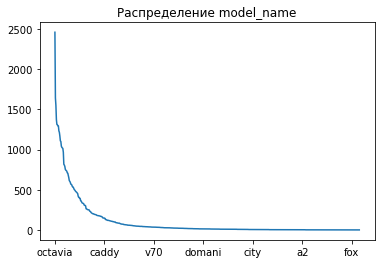

In [252]:
new_df.model_name.value_counts().plot()
plt.title('Распределение model_name');

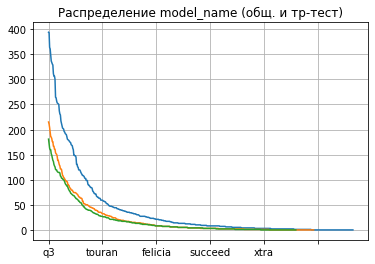

In [253]:
new_df.model_name.value_counts()[50:].plot()
new_df[new_df['sample'] == 0].model_name.value_counts()[50:].plot()
new_df[new_df['sample'] == 1].model_name.value_counts()[50:].plot()
plt.grid()
plt.title('Распределение model_name (общ. и тр-тест)');

Из-за черезмерного кол-ва имен в колонке model_name заменяем наименее частые имена (меньше 50, т.е. примерно по 25 в трейн и тесте, по принципу "лодыжки") на "other".

In [254]:
sss = new_df.model_name.value_counts()
new_df['model_name'] = new_df.model_name.apply(lambda x: x if sss[x] > 50 else 'other')
new_df['model_name'].value_counts()

other              5432
octavia            2457
polo               1641
5                  1548
outland            1371
                   ... 
jx                   54
smaybach             53
civicfio             53
v90crosscountry      52
montosport           51
Name: model_name, Length: 163, dtype: int64

In [255]:
new_df['name'].value_counts()

1.6 AT (110 л.с.)            1592
1.4 AMT (150 л.с.)            831
2.0 CVT (146 л.с.) 4WD        701
1.6 MT (110 л.с.)             638
1.6 MT (102 л.с.)             615
                             ... 
Fielder 1.5 MT (109 л.с.)       1
2.4 MT (108 л.с.) 4WD           1
2.5d MT (109 л.с.)              1
1.6 AT (116 л.с.)               1
1.8 AT (117 л.с.) 4WD           1
Name: name, Length: 3402, dtype: int64

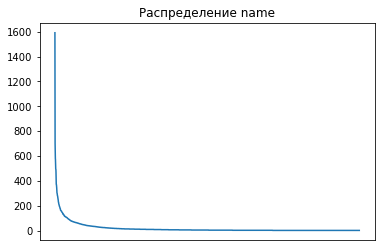

In [256]:
new_df.name.value_counts().plot();
plt.xticks([])
plt.title('Распределение name');


Аналогично в колонке name много разных написаний и лишней инф. Очистим ее, чтобы одинаковые модели, по возможности, совпадали и удалим наименее частые категории (заменим их на "other").

In [257]:
new_df['name'] = new_df['name'].apply(lambda x: re.sub(
                        '[^a-z]','',re.sub('\(.*\)','',x.lower().replace('wd', ''))))

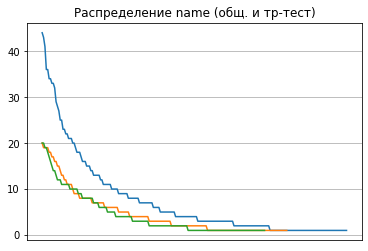

In [258]:
new_df.name.value_counts()[50:].plot()
new_df[new_df['sample'] == 0].name.value_counts()[50:].plot()
new_df[new_df['sample'] == 1].name.value_counts()[50:].plot()
plt.xticks([])
plt.grid()
plt.title('Распределение name (общ. и тр-тест)');

In [259]:
sss = new_df.name.value_counts()
new_df['name'] = new_df.name.apply(lambda x: x if sss[x] > 50 else 'other')
new_df['name'].value_counts()

at                  20833
mt                  10115
cvt                  7899
amt                  6240
dat                  3944
iat                  2524
ddat                 2268
other                1785
dmt                  1171
dxdrivedat           1026
damt                  776
ixdriveat             751
longat                529
fxat                  520
amgat                 419
imt                   299
hhybcvt               203
gat                   197
cdidat                178
dsgamt                170
hybcvt                168
tfsiamt               162
cdibluetecdat         150
mat                   149
tat                   141
hybat                 136
hybamt                115
amtamt                115
lixdriveat            103
tdidat                 97
xiat                   96
mddat                  91
electroat              89
liat                   88
exat                   88
lat                    86
gtronicat              86
amgsat                 82
blueefficien

In [260]:
# Удаляем ненужные или колонки с дублирующейся инф.
new_df = new_df.drop(columns=[
    'price_currency', 'владение', 'таможня', 'complectation_dict',
    'model_info', 'super_gen', 'vehicle_configuration'
])

In [261]:
new_df[new_df['body_type'] == 'лимузин']

,body_type,brand,car_url,color,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,...,production_date,vehicle_transmission,vendor,owners,ПТС,привод,руль,состояние,price,sample
15962,лимузин,mercedes,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,"Продается Мерседес Бенц Пульман,автомобиль в и...",6.2,525,"{""cruise-control"":true,""tinted-glass"":true,""ro...",бензин,147000,...,2008,автоматическая,EUROPEAN,3 или более,Оригинал,задний,Левый,Не требует ремонта,0.0,0
16908,лимузин,mercedes,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,S600 GUARD. Бронированный автомобиль B6/B7. Ма...,5.5,517,"{""roller-blind-for-rear-window"":true,""esp"":tru...",бензин,138000,...,2010,автоматическая,EUROPEAN,2 владельца,Оригинал,задний,Левый,Не требует ремонта,0.0,0
17061,лимузин,mercedes,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,"Автомобиль бронированный, степень защиты Б6-Б7...",5.5,500,NaN,бензин,6500,...,2003,автоматическая,EUROPEAN,1 владелец,Оригинал,задний,Левый,Не требует ремонта,0.0,0
17555,лимузин,mercedes,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,Mercedes-Benz Pullman (оригинальное заводское ...,5.8,367,NaN,бензин,75000,...,2002,автоматическая,EUROPEAN,2 владельца,Дубликат,задний,Левый,Не требует ремонта,0.0,0
31727,лимузин,mercedes,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,Удлиненный заводской Pullman на базе W140 (воо...,6.0,394,NaN,бензин,21291,...,1996,автоматическая,EUROPEAN,2 владельца,Оригинал,задний,Левый,Не требует ремонта,0.0,0
31882,лимузин,mercedes,https://auto.ru/cars/used/sale/mercedes/s_klas...,синий,Автомобиль из ГОН (Кремль 9) возивший первых л...,5.8,367,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,89200,...,2003,автоматическая,EUROPEAN,3 или более,Оригинал,задний,Левый,Не требует ремонта,0.0,0
50784,лимузин,mercedes-benz,https://auto.ru/cars/used/sale/mercedes/s_klas...,синий,Автомобиль из ГОН (Кремль 9) возивший первых л...,5.8,367,"{'cruise-control': 1, 'asr': 1, 'esp': 1, 'air...",бензин,89200,...,2003,автоматическая,EUROPEAN,3 или более,Оригинал,задний,Левый,Не требует ремонта,7500000.0,1


In [262]:
new_df['number_of_doors'] = new_df['number_of_doors'].astype('int8')
new_df['number_of_doors'].value_counts()

5    37948
4    23678
2     1887
3      986
0        1
Name: number_of_doors, dtype: int64

В тестовых данных есть один раритетный автомобиль без дверей, к сожалению в трейновом датафрейме таких машин нет и удалить его тоже нельзя. Поэтому заменим на 2.

In [263]:
new_df.loc[new_df['number_of_doors'] < 2, 'number_of_doors'] = 2

In [264]:
new_df.body_type.value_counts()
# new_df[new_df['sample']==0].body_type.value_counts()

внедорожник 5 дв.          25602
седан                      22181
лифтбек                     4617
хэтчбек 5 дв.               3833
универсал 5 дв.             2162
минивэн                     1640
купе                        1338
компактвэн                   983
хэтчбек 3 дв.                724
пикап двойная кабина         491
купе-хардтоп                 221
внедорожник 3 дв.            197
кабриолет                    158
фургон                       133
родстер                      127
микровэн                      32
седан-хардтоп                 25
пикап одинарная кабина         9
лимузин                        7
пикап полуторная кабина        7
седан 2 дв.                    6
внедорожник открытый           4
тарга                          2
фастбек                        1
Name: body_type, dtype: int64

Типы кузова - группируем однородные. Лимузин один в трен. датасете и 6 шт. в тесте - заменяем на наиболее близкий по ценовой категории внедорожник.

In [265]:
rep_dict = {
    'тарга': 'родстер',
    'седан': 'седан',
    'внедорожник': 'внедорожник',
    'пикап': 'пикап',
    'универсал': 'универсал',
    'фастбек': 'хэтчбек',
    'хэтчбек': 'хэтчбек',
    'микровэн': 'компактвэн',
    'лимузин': 'внедорожник'
}


def rep_body(r):
    for k, v in rep_dict.items():
        if k in r:
            return v
    return r


new_df['body_type'] = new_df.body_type.apply(rep_body)

In [266]:
new_df.body_type.value_counts()


внедорожник     25810
седан           22212
лифтбек          4617
хэтчбек          4558
универсал        2162
минивэн          1640
купе             1338
компактвэн       1015
пикап             507
купе-хардтоп      221
кабриолет         158
фургон            133
родстер           129
Name: body_type, dtype: int64

In [267]:
# Определяем возраст машины и корректируем на 2 года для соотв. тестовым данным.
new_df['age'] = 2020 - new_df['production_date'] + np.where(new_df['sample'] == 1, 2, 0)

In [268]:
new_df.drop(columns=['production_date'], inplace=True)

In [269]:
new_df['owners'] = new_df['owners'].map({'3 или более': 3,
                                        '1\xa0владелец':1,
                                        '2\xa0владельца':2})
new_df['owners'].value_counts()

3    27652
1    20554
2    16294
Name: owners, dtype: int64

In [270]:
new_df.isna().sum()

body_type                  0
brand                      0
car_url                    0
color                      0
description              585
engine_displacement        0
engine_power               0
equipment_dict          9996
fuel_type                  0
mileage                    0
model_name                 0
name                       0
number_of_doors            0
vehicle_transmission       0
vendor                     0
owners                     0
ПТС                        1
привод                     0
руль                       0
состояние                  0
price                      0
sample                     0
age                        0
dtype: int64

Для машин без описания создадим колонку description_isna, а пропуски заменим на пустые строки.

In [271]:
new_df['description_isna'] = pd.isna(new_df['description']).astype('uint8')
new_df['description'] = new_df['description'].fillna('')
new_df['description'].isna().sum()

0

Пропуск в ПТС заменим на моду

In [272]:
new_df['ПТС'].fillna(new_df['ПТС'].mode()[0], inplace=True)
new_df['ПТС'].isna().sum()

0

In [273]:
new_df['состояние'].value_counts()

Не требует ремонта    64497
Битый / не на ходу        3
Name: состояние, dtype: int64

В колонке "состояние" есть только 3 битых авто. Это только помешает модели поэтому удалим ее. 

In [274]:
del(new_df['состояние'])

In [275]:
bin_cols = ['vendor', 'ПТС', 'руль']


Переводим колонки с 2мя категориями в бинарный вид.

In [276]:
new_df['ПТС'] = new_df['ПТС'].map({'Оригинал': 1, 'Дубликат':0})
new_df['vendor'] = new_df['vendor'].map({'EUROPEAN': 1, 'JAPANESE':0})
new_df['руль'] = new_df['руль'].map({'Левый': 1, 'Правый':0})

In [277]:
# new_df[new_df.price==new_df.price.max()]['car_url'].values

In [278]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64500 entries, 0 to 64499
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             64500 non-null  object 
 1   brand                 64500 non-null  object 
 2   car_url               64500 non-null  object 
 3   color                 64500 non-null  object 
 4   description           64500 non-null  object 
 5   engine_displacement   64500 non-null  float64
 6   engine_power          64500 non-null  int32  
 7   equipment_dict        54504 non-null  object 
 8   fuel_type             64500 non-null  object 
 9   mileage               64500 non-null  int64  
 10  model_name            64500 non-null  object 
 11  name                  64500 non-null  object 
 12  number_of_doors       64500 non-null  int8   
 13  vehicle_transmission  64500 non-null  object 
 14  vendor                64500 non-null  int64  
 15  owners             

### EDA. Выбросы

In [279]:
# import pandas_profiling
# path=''
# pandas_profiling.ProfileReport(new_df[new_df['sample']==1]).to_file(path+"prof_train_df_6.html")
# pandas_profiling.ProfileReport(new_df[new_df['sample']==0]).to_file(path+"prof_test_df_6.html")

Посмотрим на выбросы числовых колонок.

In [280]:
def boxplot_col(c):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=new_df.loc[new_df['sample'] == 1, c], ax=ax, orient='h',)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + c)
    plt.grid()
    plt.show()

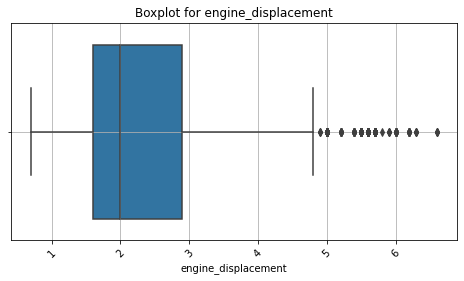

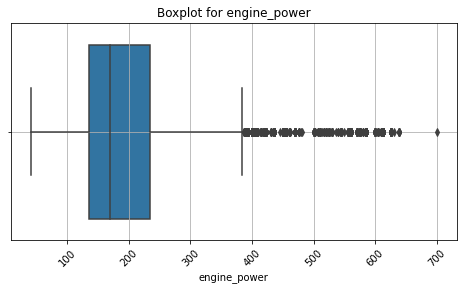

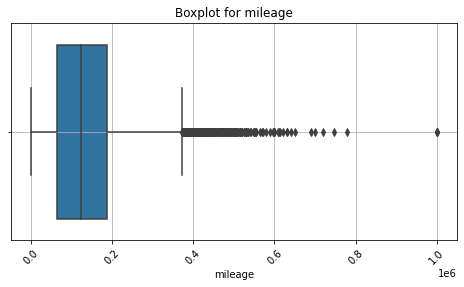

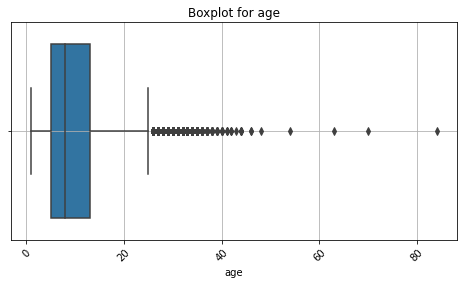

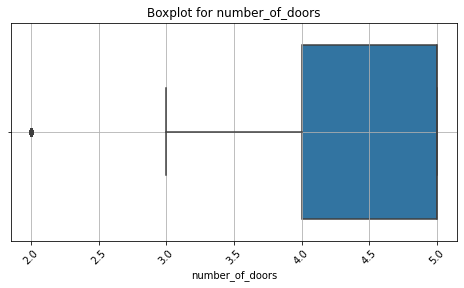

In [281]:
for col in ['engine_displacement', 'engine_power', 'mileage','age','number_of_doors']:
    boxplot_col(col);

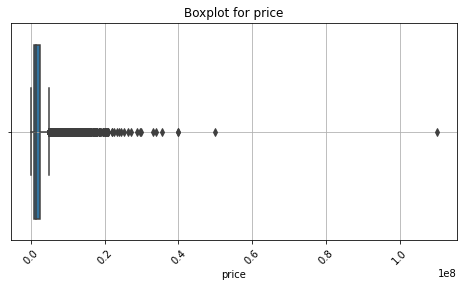

In [282]:
boxplot_col('price')


Как видно из графиков в данных есть большое кол-во выбросов. Однако это не ошибки, а реальные данные которые могут повлиять на результат. 

Заменим все автомобили старше 60 лет на 60 и удалим автомобили с чересчур завышенной ценной т.к. после проверки на сайте эти автомобили оказались коллекционными (к тому же мы видим лишь цену предложения продавца, а не сделки).



In [283]:
new_df.loc[new_df['age'] > 60, 'age'] = 60
new_df.loc[new_df['number_of_doors'] == 0, 'number_of_doors'] = 4
# del new_df.loc[[new_df['price']>0.39e8],:]
new_df = new_df.drop(new_df[new_df['price'] > 0.39e8].index).reset_index(drop=True)

In [284]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
engine_displacement,64496.0,2.375892,9.553423e-01,0.7,1.60,2.0,3.0,6.6
engine_power,64496.0,188.740666,8.834802e+01,30.0,129.00,169.0,235.0,700.0
mileage,64496.0,149756.281924,9.847126e+04,1.0,78533.75,137000.0,200107.5,1000000.0
number_of_doors,64496.0,4.514559,6.752158e-01,2.0,4.00,5.0,5.0,5.0
vendor,64496.0,0.560732,4.963017e-01,0.0,0.00,1.0,1.0,1.0
owners,64496.0,2.110069,8.574823e-01,1.0,1.00,2.0,3.0,3.0
ПТС,64496.0,0.868348,3.381142e-01,0.0,1.00,1.0,1.0,1.0
руль,64496.0,0.945981,2.260567e-01,0.0,1.00,1.0,1.0,1.0
price,64496.0,903834.009923,1.693513e+06,0.0,0.00,0.0,1285407.5,35500000.0
sample,64496.0,0.462199,4.985729e-01,0.0,0.00,0.0,1.0,1.0


In [285]:
cat_cols = new_df.columns[new_df.dtypes == 'object'].tolist()
not_cat_cols = new_df.columns[new_df.dtypes != 'object'].tolist()
print(cat_cols, not_cat_cols)

['body_type', 'brand', 'car_url', 'color', 'description', 'equipment_dict', 'fuel_type', 'model_name', 'name', 'vehicle_transmission', 'привод'] ['engine_displacement', 'engine_power', 'mileage', 'number_of_doors', 'vendor', 'owners', 'ПТС', 'руль', 'price', 'sample', 'age', 'description_isna']


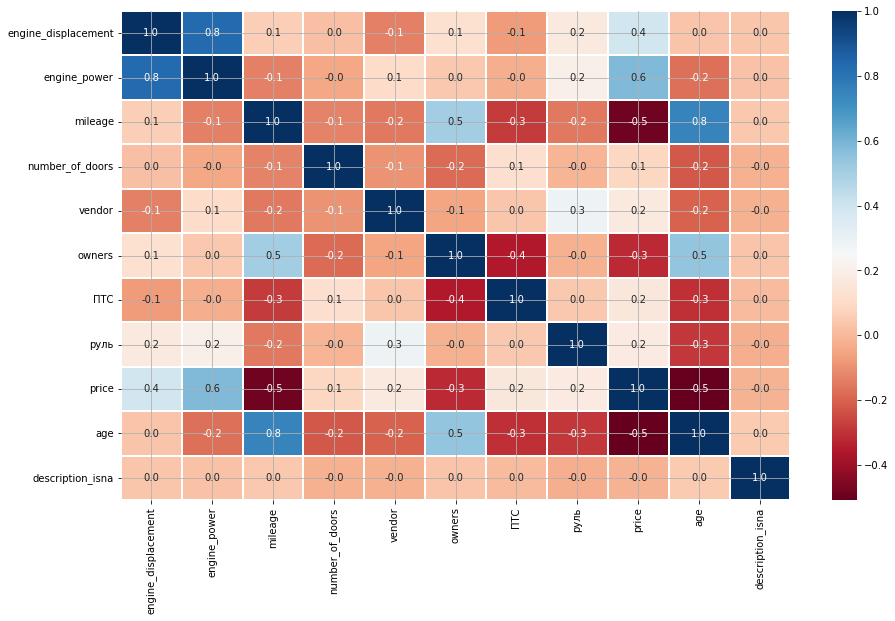

In [286]:
def show_corr(df):
    plt.figure(figsize=(15,9))
    sns.heatmap(df.corr(), #vmin=0, vmax=1, square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")
    plt.grid()
    plt.show();
    
show_corr(new_df[new_df['sample']==1][not_cat_cols].drop(columns=['sample']))

## Добавление новых признаков

### Обработка колонки description

Так как у большинства машин есть описание, попробуем перевести его в цифровой вид, предварительно обработав, и найдя слова с наибольшими весами использовать их для улучшения предсказания.

In [287]:
#Create lemmatizer and stopwords list
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

In [288]:
descr_for_df = new_df['description'].apply(lambda x: x.lower()).str.replace(r'[^а-я ]', '', regex=True)

Для начала удалим все наиболее часто встречающиеся слова из описаний, каждое слово приведем к начальной форме и добавим обновленное описание в колонку new_description.

Лемматизацию делаем с помощью библиотеки pymystem3. Она запускается как отдельная программа, поэтому при обработке записей по одной она работает очень медленно, но при объединении многих записей с искусственным разделителем, намного быстрее. Поскольку весь объем данных не помещается в память, пришлось делить на шаги по 1000 записей.

In [289]:
step = 1000
new_df['new_description'] = ''
col_ind = new_df.columns.tolist().index('new_description')
maxi = (len(new_df) // step) + 1
for i in range(maxi):
    descr_for_df1 = mystem.lemmatize(' breakit '.join(
        descr_for_df.values[i * step:(i + 1) * step]))
    descr = []
    curr = []
    for word in descr_for_df1:
        if word not in russian_stopwords + [
                'автомобилей', 'автомобили', 'автомобиль', 'авто', 'машина', ' ', '\n', '']:
            if word == 'breakit':
                descr.append(re.sub('[\s]+', ' ', ' '.join(curr)))
                curr = []
            else:
                curr.append(word)
    descr.append(re.sub(' +', ' ', ' '.join(curr)))
    new_df.iloc[i * step:(i + 1) * step, col_ind] = descr

new_df[['description', 'new_description']]

,description,new_description
0,"Все автомобили, представленные в продаже, прох...",представлять продажа проходить тщательный пров...
1,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,лот автопрага северданный проходить диагностик...
2,"Все автомобили, представленные в продаже, прох...",представлять продажа проходить тщательный пров...
3,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,комплект зимний летний резина сезон подарокрас...
4,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,лот автопрага севервы мочь получать скидка дан...
...,...,...
64491,Куплена у официального дилера\nЗа все время эк...,купить официальный дилераза весь время эксплуа...
64492,Машина полностью исправна. Все вопросы по теле...,полностью исправный весь вопрос телефон высыла...
64493,"Продам свой автомобиль в идеальном состояние,б...",продавать свой идеальный состояниебез вложение...
64494,Данный автомобиль представлен АВТОБАН ЭКСПЕРТ ...,данный представлять автобан эксперт крупный ко...


Затем с помощью библиотеки TfidfVectorizer оцениваем важность слова в описании и оставляем только 200 наиболее важных. (Изначально пробовал 600, но эти поля не улучшают предсказаний, оставлено для отчета).

In [290]:
#Create lemmatizer and stopwords list
vectorizer = TfidfVectorizer(min_df=50, max_df=0.8, max_features=200)
xtrain = vectorizer.fit_transform(new_df.new_description)
print(xtrain)
vectorizer.get_feature_names_out()

  (0, 173)	0.12562732855186332
  (0, 28)	0.13652871207525774
  (0, 165)	0.12801294821111986
  (0, 40)	0.11934062513767768
  (0, 124)	0.2843507411589493
  (0, 98)	0.09223580486157797
  (0, 23)	0.1338619859318908
  (0, 121)	0.09713149984705417
  (0, 6)	0.14520776852585207
  (0, 21)	0.1303497209400921
  (0, 58)	0.11796902358658105
  (0, 151)	0.28424117658756626
  (0, 66)	0.1521473285337461
  (0, 39)	0.11277058655318989
  (0, 92)	0.14519932591399945
  (0, 75)	0.3682282570298023
  (0, 169)	0.14525846137999424
  (0, 170)	0.13095572105943762
  (0, 137)	0.2564901081919006
  (0, 76)	0.14221454643566656
  (0, 13)	0.11680497389722057
  (0, 115)	0.11805070458904998
  (0, 109)	0.40331857840238006
  (0, 19)	0.12446024248851839
  (0, 31)	0.10789836219932282
  :	:
  (64495, 184)	0.1431244811312087
  (64495, 154)	0.10140909915312414
  (64495, 97)	0.07923157171825404
  (64495, 132)	0.300423530960215
  (64495, 123)	0.06416498304162478
  (64495, 77)	0.08086755684767535
  (64495, 168)	0.09206679664211377
 

array(['автоматический', 'автосалон', 'адрес', 'ама', 'антиблокировочный',
       'багажник', 'банк', 'безопасность', 'боковой', 'большой',
       'бортовой', 'ваш', 'весь', 'взнос', 'вид', 'владелец', 'вложение',
       'водитель', 'возможность', 'возможный', 'вопрос', 'время',
       'выгода', 'выгодный', 'выкуп', 'гарантия', 'год', 'готовый',
       'данный', 'датчик', 'дверь', 'двигатель', 'день', 'детский',
       'диагностика', 'дилер', 'дилерский', 'диск', 'дождь', 'документ',
       'дополнительный', 'доступ', 'дтп', 'задний', 'замена', 'заменять',
       'замок', 'защита', 'звонить', 'зеркало', 'зимний', 'зонный',
       'идеальный', 'иммобилайзер', 'история', 'каждый', 'камера',
       'капот', 'каско', 'климат', 'климатконтроль', 'ключ', 'км', 'кожа',
       'кожаный', 'колесо', 'комиссия', 'компания', 'комплексный',
       'комплект', 'комплектация', 'компьютер', 'кондиционер', 'контроль',
       'коробка', 'кредит', 'кредитный', 'кредитование', 'крепление',
       'круизко

Переводим спарсматрицу в датафрейм.

In [291]:
xx = pd.DataFrame.sparse.from_spmatrix(xtrain, index=new_df.index)
xx.columns = tf_idx = ['v_' + str(c) for c in xx.columns]
xx

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_190,v_191,v_192,v_193,v_194,v_195,v_196,v_197,v_198,v_199
0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.145208,0.000000,0.000000,0.000000,...,0.000000,0.0,0.107061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093950
1,0.0,0.00000,0.000000,0.0,0.073185,0.0,0.000000,0.061417,0.076094,0.000000,...,0.070504,0.0,0.061575,0.074735,0.000000,0.069459,0.000000,0.000000,0.071483,0.054034
2,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.145208,0.000000,0.000000,0.000000,...,0.000000,0.0,0.107061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093950
3,0.0,0.12233,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.124997,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.00000,0.000000,0.0,0.081103,0.0,0.000000,0.068062,0.084327,0.000000,...,0.078132,0.0,0.068236,0.000000,0.000000,0.076974,0.000000,0.000000,0.079217,0.059880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64491,0.0,0.00000,0.137083,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.139659,0.000000,0.143088,0.000000,0.000000,0.087888
64492,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
64493,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292756,0.000000
64494,0.0,0.00000,0.000000,0.0,0.062612,0.0,0.000000,0.210176,0.065101,0.000000,...,0.120637,0.0,0.000000,0.000000,0.000000,0.059424,0.075262,0.063482,0.000000,0.000000


In [292]:
df_with_words = pd.concat([new_df, xx], axis=1)
df_with_words

,body_type,brand,car_url,color,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,...,v_190,v_191,v_192,v_193,v_194,v_195,v_196,v_197,v_198,v_199
0,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2,105,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,0.000000,0.0,0.107061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093950
1,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,0.070504,0.0,0.061575,0.074735,0.000000,0.069459,0.000000,0.000000,0.071483,0.054034
2,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8,152,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,0.000000,0.0,0.107061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093950
3,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,...,0.078132,0.0,0.068236,0.000000,0.000000,0.076974,0.000000,0.000000,0.079217,0.059880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64491,универсал,audi,https://auto.ru/cars/used/sale/audi/allroad/11...,коричневый,Куплена у официального дилера\nЗа все время эк...,3.0,245,"{'cruise-control': 1, 'esp': 1, 'usb': 1, 'xen...",дизель,142639,...,0.000000,0.0,0.000000,0.000000,0.139659,0.000000,0.143088,0.000000,0.000000,0.087888
64492,внедорожник,volvo,https://auto.ru/cars/used/sale/volvo/xc90/1097...,чёрный,Машина полностью исправна. Все вопросы по теле...,3.2,238,{'gbo': 1},бензин,280000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
64493,седан,bmw,https://auto.ru/cars/used/sale/bmw/7er/1105170...,чёрный,"Продам свой автомобиль в идеальном состояние,б...",3.0,381,"{'cruise-control': 1, 'roller-blind-for-rear-w...",дизель,147000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292756,0.000000
64494,внедорожник,volkswagen,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,Данный автомобиль представлен АВТОБАН ЭКСПЕРТ ...,3.6,249,"{'cruise-control': 1, 'tinted-glass': 1, 'esp'...",бензин,131188,...,0.120637,0.0,0.000000,0.000000,0.000000,0.059424,0.075262,0.063482,0.000000,0.000000


### Обработка колонки equipment_dict

In [317]:
new_df['equipment_dict'][0]

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

В колонке equipment_dict содержится довольно много информации об автомобиле которая может помочь в предсказании.

Разобьем каждый словарь на дополнительные колонки по ключам.

In [318]:
def new_col(df):
    a = df.copy()
    counter = 0
    try:
        for i, va in df['equipment_dict'].items():
            if va is not np.nan:
                if type(va) != dict:
                    dic = eval(va.replace('true', '1').replace('false', '0'))
                else:
                    dic = eval(
                        str(va).replace('true', '1').replace('false', '0'))
                for k, v in dic.items():
                    a.loc[i, 'equipment_dict_' + k] = v
            counter += 1
            if counter % 5000 == 0:
                print(counter)
    except:
        print(i, va)
    return a


all_coll_df = new_col(df_with_words)
all_coll_df

C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\pandas\core\indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


,body_type,brand,car_url,color,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,...,equipment_dict_4R2,equipment_dict_4R3,equipment_dict_6R1,equipment_dict_9T1,equipment_dict_3Q6,equipment_dict_migration-flag,equipment_dict_duo-body-color,equipment_dict_rcta,equipment_dict_rear-seat-memory,equipment_dict_dual-xenon
0,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2,105,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8,152,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64491,универсал,audi,https://auto.ru/cars/used/sale/audi/allroad/11...,коричневый,Куплена у официального дилера\nЗа все время эк...,3.0,245,"{'cruise-control': 1, 'esp': 1, 'usb': 1, 'xen...",дизель,142639,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
64492,внедорожник,volvo,https://auto.ru/cars/used/sale/volvo/xc90/1097...,чёрный,Машина полностью исправна. Все вопросы по теле...,3.2,238,{'gbo': 1},бензин,280000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64493,седан,bmw,https://auto.ru/cars/used/sale/bmw/7er/1105170...,чёрный,"Продам свой автомобиль в идеальном состояние,б...",3.0,381,"{'cruise-control': 1, 'roller-blind-for-rear-w...",дизель,147000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64494,внедорожник,volkswagen,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,Данный автомобиль представлен АВТОБАН ЭКСПЕРТ ...,3.6,249,"{'cruise-control': 1, 'tinted-glass': 1, 'esp'...",бензин,131188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим все колонки в которых непустых значений меньше 1%, т.е. 640. Это редкие или ошибочные варианты комплектации.

In [319]:
col_to_drop = all_coll_df.loc[:, (all_coll_df.notna().sum() < 640)].columns.tolist()
all_coll_df.drop(columns=col_to_drop, inplace=True)
all_coll_df

,body_type,brand,car_url,color,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,...,equipment_dict_massage-seats,equipment_dict_easy-trunk-opening,equipment_dict_entertainment-system-for-rear-seat-passengers,equipment_dict_rear-seat-heat-vent,equipment_dict_power-latching-doors,equipment_dict_air-suspension,equipment_dict_wheel-memory,equipment_dict_20-inch-wheels,equipment_dict_21-inch-wheels,equipment_dict_body-kit
0,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2,105,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8,152,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,лифтбек,skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64491,универсал,audi,https://auto.ru/cars/used/sale/audi/allroad/11...,коричневый,Куплена у официального дилера\nЗа все время эк...,3.0,245,"{'cruise-control': 1, 'esp': 1, 'usb': 1, 'xen...",дизель,142639,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
64492,внедорожник,volvo,https://auto.ru/cars/used/sale/volvo/xc90/1097...,чёрный,Машина полностью исправна. Все вопросы по теле...,3.2,238,{'gbo': 1},бензин,280000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64493,седан,bmw,https://auto.ru/cars/used/sale/bmw/7er/1105170...,чёрный,"Продам свой автомобиль в идеальном состояние,б...",3.0,381,"{'cruise-control': 1, 'roller-blind-for-rear-w...",дизель,147000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64494,внедорожник,volkswagen,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,Данный автомобиль представлен АВТОБАН ЭКСПЕРТ ...,3.6,249,"{'cruise-control': 1, 'tinted-glass': 1, 'esp'...",бензин,131188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
save_obj(all_coll_df, 'df_for_proj_6.pkl')

Посмотрим на корреляции колонок со словами с ценой. 

In [321]:
# tf_idx =  [c for c in all_coll_df.columns.tolist() if c[:2]=='v_']

thresh_corr = 0.16
# good_corr = all_coll_df.loc[all_coll_df['sample']==1,tf_idx].corrwith(all_coll_df[all_coll_df['sample']==1].price)
good_corr = all_coll_df.loc[all_coll_df['sample'] == 1, tf_idx].corrwith(
    all_coll_df.loc[all_coll_df['sample'] == 1, 'price'])
good_corr_cols = good_corr[np.abs(good_corr) > thresh_corr].sort_values(
    ascending=False).index.tolist()
good_corr_cols

['v_164',
 'v_185',
 'v_106',
 'v_178',
 'v_112',
 'v_111',
 'v_163',
 'v_125',
 'v_157',
 'v_0']

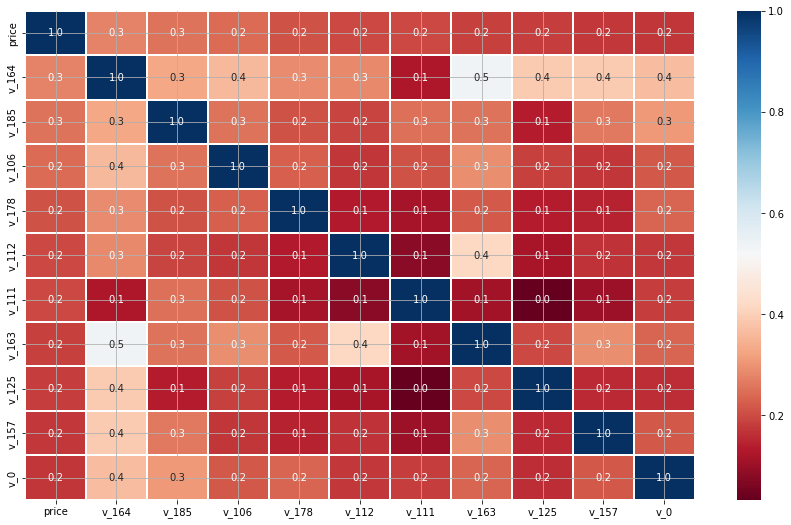

In [322]:
show_corr(all_coll_df.loc[all_coll_df['sample'] == 1, ['price'] + good_corr_cols])

Добавим колонку equipment_dict_isna и удалим ненужные нам колонки.

In [323]:
all_coll_df['equipment_dict_isna'] = pd.isna(all_coll_df['equipment_dict']).astype('uint8')
all_coll_df = all_coll_df.drop(columns=['car_url', 'description', 'new_description', 'equipment_dict'])

C:\Users\Mike\AppData\Local\Temp/ipykernel_6860/4064347909.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  all_coll_df['equipment_dict_isna'] = pd.isna(all_coll_df['equipment_dict']).astype('uint8')


Заполняем пропуски в колонках equipment_dict.

In [324]:
for col in all_coll_df.columns.tolist():
    if 'equipment_dict' in str(col):
        all_coll_df[col] = all_coll_df[col].fillna(0).astype('int8')
all_coll_df.iloc[:, 20:]

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,equipment_dict_easy-trunk-opening,equipment_dict_entertainment-system-for-rear-seat-passengers,equipment_dict_rear-seat-heat-vent,equipment_dict_power-latching-doors,equipment_dict_air-suspension,equipment_dict_wheel-memory,equipment_dict_20-inch-wheels,equipment_dict_21-inch-wheels,equipment_dict_body-kit,equipment_dict_isna
0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.145208,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.00000,0.000000,0.0,0.073185,0.0,0.000000,0.061417,0.076094,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.145208,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.12233,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.124997,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.00000,0.000000,0.0,0.081103,0.0,0.000000,0.068062,0.084327,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64491,0.0,0.00000,0.137083,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
64492,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
64493,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
64494,0.0,0.00000,0.000000,0.0,0.062612,0.0,0.000000,0.210176,0.065101,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [325]:
all_coll_df.isna().sum().sum()

0

## Кодирование категориальных признаков

In [326]:
all_coll_df_cat_cols = all_coll_df.columns[all_coll_df.dtypes == 'object'].tolist()
# all_coll_df.loc[:,all_coll_df_cat_cols] = all_coll_df.loc[:,all_coll_df_cat_cols].astype('category')

In [327]:
all_coll_df.iloc[:, :20].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64496 entries, 0 to 64495
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             64496 non-null  object 
 1   brand                 64496 non-null  object 
 2   color                 64496 non-null  object 
 3   engine_displacement   64496 non-null  float64
 4   engine_power          64496 non-null  int32  
 5   fuel_type             64496 non-null  object 
 6   mileage               64496 non-null  int64  
 7   model_name            64496 non-null  object 
 8   name                  64496 non-null  object 
 9   number_of_doors       64496 non-null  int8   
 10  vehicle_transmission  64496 non-null  object 
 11  vendor                64496 non-null  int64  
 12  owners                64496 non-null  int64  
 13  ПТС                   64496 non-null  int64  
 14  привод                64496 non-null  object 
 15  руль               

Для всех категориальных колонок сравним количество значений в категориях в трейне и тесте, их общую сумму и сумму по сэмплам.

In [328]:
val_cat_dict = {}
for col in all_coll_df_cat_cols:
    val_cat_dict[col] = pd.concat(
        (all_coll_df.loc[all_coll_df['sample'] == 1, col].value_counts(),
         all_coll_df.loc[all_coll_df['sample'] == 0, col].value_counts()),
        axis=1)
    val_cat_dict[col].columns = ['s1', 's0']
    val_cat_dict[col]['sum'] = val_cat_dict[col].sum(axis=1)
    val_cat_dict[col] = val_cat_dict[col].sort_values('sum', ascending=False)

In [329]:
for col in all_coll_df_cat_cols:
    display(col, val_cat_dict[col])

'body_type'

,s1,s0,sum
внедорожник,13458,12352,25810
седан,9045,13165,22210
лифтбек,2385,2232,4617
хэтчбек,1948,2610,4558
универсал,886,1276,2162
минивэн,644,995,1639
купе,513,824,1337
компактвэн,519,496,1015
пикап,217,290,507
купе-хардтоп,63,158,221


'brand'

,s1,s0,sum
volkswagen,2756.0,4404.0,7160.0
bmw,2677.0,4473.0,7150.0
nissan,2723.0,4393.0,7116.0
toyota,2746.0,3913.0,6659.0
audi,2744.0,3421.0,6165.0
mitsubishi,2751.0,2843.0,5594.0
skoda,2817.0,2741.0,5558.0
mercedes,NaN,4180.0,4180.0
honda,2761.0,1150.0,3911.0
volvo,1752.0,1463.0,3215.0


'color'

,s1,s0,sum
чёрный,8488,11010,19498
белый,7033,6133,13166
серый,4138,3984,8122
серебристый,2720,4113,6833
синий,2584,3289,5873
коричневый,1431,1501,2932
красный,1345,1531,2876
зелёный,556,952,1508
бежевый,538,639,1177
голубой,277,457,734


'fuel_type'

,s1,s0,sum
бензин,24444,28608,53052
дизель,4743,5800,10543
гибрид,554,223,777
электро,69,55,124


'model_name'

,s1,s0,sum
other,2597.0,2833.0,5430.0
octavia,1039.0,1418.0,2457.0
polo,917.0,724.0,1641.0
5,522.0,1026.0,1548.0
outland,827.0,544.0,1371.0
...,...,...,...
jx,29.0,25.0,54.0
civicfio,47.0,6.0,53.0
smaybach,NaN,53.0,53.0
v90crosscountry,44.0,8.0,52.0


'name'

,s1,s0,sum
at,9894,10937,20831
mt,4120,5995,10115
cvt,4147,3752,7899
amt,3113,3127,6240
dat,1776,2168,3944
iat,771,1753,2524
ddat,1097,1170,2267
other,838,946,1784
dmt,374,797,1171
dxdrivedat,517,509,1026


'vehicle_transmission'

,s1,s0,sum
автоматическая,16493,19596,36089
механическая,4694,7209,11903
вариатор,4622,3999,8621
роботизированная,4001,3882,7883


'привод'

,s1,s0,sum
полный,14486,15020,29506
передний,13143,15565,28708
задний,2181,4101,6282


In [330]:
all_coll_df['brand'].value_counts()

volkswagen       7160
bmw              7150
nissan           7116
toyota           6659
audi             6165
mitsubishi       5594
skoda            5558
mercedes         4180
honda            3911
volvo            3215
lexus            3076
mercedes-benz    2737
infiniti         1975
Name: brand, dtype: int64

In [331]:
all_coll_df.loc[all_coll_df['brand'] == 'mercedes-benz', 'brand'] = 'mercedes'
all_coll_df.loc[all_coll_df['color'] == 'розовый', 'color'] = 'пурпурный'

Для кодировки используем метод "target-encoding".

In [332]:
for col in all_coll_df_cat_cols:
    print(col)
    subs = dict(all_coll_df.groupby(col).price.mean().astype(int))
    all_coll_df[col] = all_coll_df[col].map(subs)

body_type
brand
color
fuel_type
model_name
name
vehicle_transmission
привод


In [333]:
all_coll_df  #.loc[:,:23].info()

,body_type,brand,color,engine_displacement,engine_power,fuel_type,mileage,model_name,name,number_of_doors,...,equipment_dict_easy-trunk-opening,equipment_dict_entertainment-system-for-rear-seat-passengers,equipment_dict_rear-seat-heat-vent,equipment_dict_power-latching-doors,equipment_dict_air-suspension,equipment_dict_wheel-memory,equipment_dict_20-inch-wheels,equipment_dict_21-inch-wheels,equipment_dict_body-kit,equipment_dict_isna
0,734064,632037,827933,1.2,105,770494,74000,492532,879386,5,...,0,0,0,0,0,0,0,0,0,0
1,734064,632037,1065391,1.6,110,770494,60563,492532,287788,5,...,0,0,0,0,0,0,0,0,0,0
2,734064,632037,935420,1.8,152,770494,88000,484731,245191,5,...,0,0,0,0,0,0,0,0,0,0
3,734064,632037,938937,1.6,110,770494,95000,492532,877133,5,...,0,0,0,0,0,0,0,0,0,0
4,734064,632037,1078663,1.8,152,770494,58536,492532,877133,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64491,531866,1006422,938937,3.0,245,1537116,142639,985847,1193615,5,...,0,0,0,0,1,0,0,0,0,0
64492,1316773,866629,1065391,3.2,238,770494,280000,1188265,877133,5,...,0,0,0,0,0,0,0,0,0,0
64493,617432,1155332,1065391,3.0,381,1537116,147000,1063332,1740021,4,...,0,0,0,0,0,0,0,0,0,0
64494,1316773,553897,1065391,3.6,249,770494,131188,983464,877133,5,...,0,0,0,0,0,0,0,0,0,0


In [334]:
equipment_dict_cols = [v for v in all_coll_df.columns if 'equipment_dict' in v]
equipment_dict_cols

['equipment_dict_engine-proof',
 'equipment_dict_tinted-glass',
 'equipment_dict_airbag-driver',
 'equipment_dict_aux',
 'equipment_dict_isofix',
 'equipment_dict_electro-window-front',
 'equipment_dict_ashtray-and-cigarette-lighter',
 'equipment_dict_airbag-passenger',
 'equipment_dict_computer',
 'equipment_dict_high-beam-assist',
 'equipment_dict_seat-transformation',
 'equipment_dict_isofix-front',
 'equipment_dict_wheel-power',
 'equipment_dict_alarm',
 'equipment_dict_lock',
 'equipment_dict_door-sill-panel',
 'equipment_dict_fabric-seats',
 'equipment_dict_electro-mirrors',
 'equipment_dict_airbag-rear-side',
 'equipment_dict_electro-window-back',
 'equipment_dict_steel-wheels',
 'equipment_dict_ptf',
 'equipment_dict_16-inch-wheels',
 'equipment_dict_rain-sensor',
 'equipment_dict_airbag-side',
 'equipment_dict_audiosystem-cd',
 'equipment_dict_dark-interior',
 'equipment_dict_cooling-box',
 'equipment_dict_condition',
 'equipment_dict_abs',
 'equipment_dict_power-child-locks-r

In [335]:
cols_to_poly = [
    'body_type', 'brand', 'color', 'engine_displacement', 'engine_power',
    'fuel_type', 'mileage', 'model_name', 'name', 'number_of_doors',
    'vehicle_transmission', 'vendor', 'owners', 'ПТС', 'привод', 'руль', 'age'
]

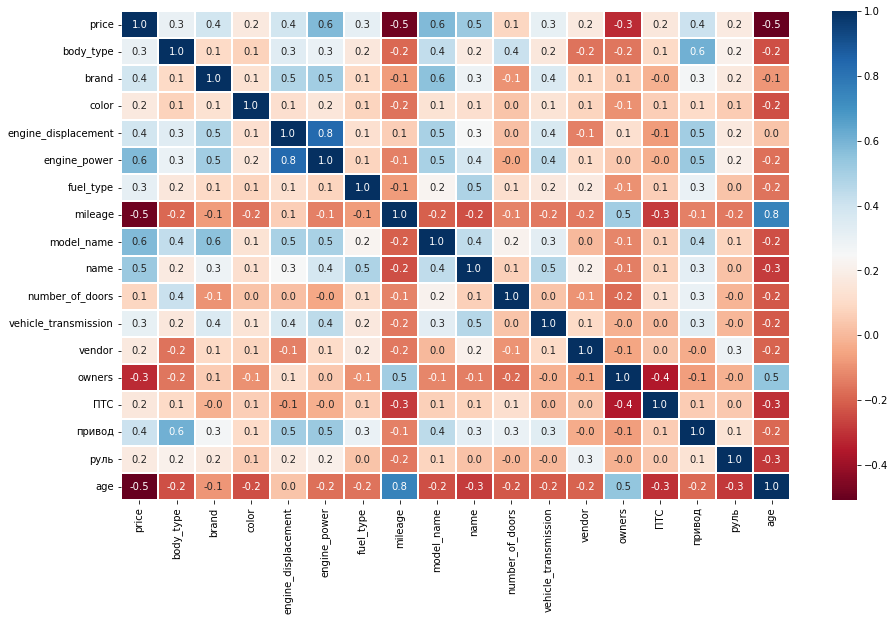

In [336]:
plt.figure(figsize=(15, 9))
sns.heatmap(all_coll_df.loc[all_coll_df['sample'] == 1, ['price'] + cols_to_poly].corr(),  
            #vmin=0, vmax=1, square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");

## Baseline модели

Пробуем несколько стандартных регрессоров.

In [337]:
X = all_coll_df[all_coll_df['sample'] == 1].drop(columns=['price', 'sample'])
y = all_coll_df[all_coll_df['sample'] == 1]['price']
# X[:3],y[:3]

LinearRegression

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

baseline_m = make_pipeline(StandardScaler(), LinearRegression())
baseline_m.fit(X_train, y_train)
predict = baseline_m.predict(X_test)
mean_absolute_percentage_error(y_test, predict)

C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\utils\validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\utils\validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\utils\validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.6097639042164509

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+equipment_dict_cols], y, 
                                                    test_size=0.3, shuffle=True, random_state=42)
baseline_m = make_pipeline(StandardScaler(), LinearRegression())
# baseline_m = LinearRegression()
baseline_m.fit(X_train, y_train)
predict = baseline_m.predict(X_test)
mean_absolute_percentage_error(y_test, predict)

0.6068948474156373

SGDRegressor

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, shuffle=True, random_state=42)
baseline_m = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet'))
baseline_m.fit(X_train, y_train)
predict = baseline_m.predict(X_test)
mean_absolute_percentage_error(y_test, predict)

C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\utils\validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\utils\validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\utils\validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9994894991936947

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly + equipment_dict_cols], y, 
                                                    test_size=0.3, shuffle=True, random_state=42)
baseline_m = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet'))
# baseline_m = SGDRegressor(penalty='l1')
baseline_m.fit(X_train, y_train)
predict = baseline_m.predict(X_test)
mean_absolute_percentage_error(y_test, predict)

C:\Users\Mike\miniconda3\envs\tkinter\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9994894991936947

RandomForestRegressor

In [342]:
# X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+equipment_dict_cols+good_corr_cols[:10]], y, 
#                                                     test_size=0.3, shuffle=True, random_state=42)
# baseline_m = RandomForestRegressor(criterion='absolute_error')
# baseline_m.fit(X_train, y_train)
# predict = baseline_m.predict(X_test)
# mean_absolute_percentage_error(y_test, predict)

CatBoostRegressor

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, shuffle=True, random_state=42)
baseline_m = CatBoostRegressor()
baseline_m.fit(X_train, y_train)
predict = baseline_m.predict(X_test)
mean_absolute_percentage_error(y_test, predict)

Learning rate set to 0.066169
0:	learn: 1901055.6828124	total: 52.6ms	remaining: 52.6s
1:	learn: 1812529.2655863	total: 90.4ms	remaining: 45.1s
2:	learn: 1732990.0106103	total: 131ms	remaining: 43.5s
3:	learn: 1657935.1871924	total: 172ms	remaining: 42.7s
4:	learn: 1585910.2921876	total: 212ms	remaining: 42.3s
5:	learn: 1519671.5914521	total: 272ms	remaining: 45.1s
6:	learn: 1458126.7673997	total: 314ms	remaining: 44.5s
7:	learn: 1399070.4520702	total: 358ms	remaining: 44.4s
8:	learn: 1345461.3438185	total: 409ms	remaining: 45s
9:	learn: 1293015.0775999	total: 467ms	remaining: 46.2s
10:	learn: 1246695.2541855	total: 524ms	remaining: 47.1s
11:	learn: 1204591.2705834	total: 604ms	remaining: 49.7s
12:	learn: 1162395.8632828	total: 654ms	remaining: 49.7s
13:	learn: 1127021.5373030	total: 701ms	remaining: 49.4s
14:	learn: 1089500.8659447	total: 737ms	remaining: 48.4s
15:	learn: 1058788.6536913	total: 777ms	remaining: 47.8s
16:	learn: 1026015.9874863	total: 811ms	remaining: 46.9s
17:	learn: 

146:	learn: 505433.1100525	total: 7.92s	remaining: 46s
147:	learn: 504501.6620918	total: 7.96s	remaining: 45.8s
148:	learn: 503828.0986959	total: 7.99s	remaining: 45.6s
149:	learn: 503401.7298881	total: 8.02s	remaining: 45.4s
150:	learn: 503215.5972850	total: 8.05s	remaining: 45.3s
151:	learn: 502944.3251224	total: 8.08s	remaining: 45.1s
152:	learn: 502282.3217425	total: 8.11s	remaining: 44.9s
153:	learn: 501584.2654249	total: 8.15s	remaining: 44.8s
154:	learn: 501423.2567769	total: 8.18s	remaining: 44.6s
155:	learn: 500999.8949665	total: 8.21s	remaining: 44.4s
156:	learn: 499162.4783485	total: 8.24s	remaining: 44.2s
157:	learn: 498818.0083019	total: 8.27s	remaining: 44.1s
158:	learn: 498686.3229364	total: 8.3s	remaining: 43.9s
159:	learn: 497524.1387956	total: 8.34s	remaining: 43.8s
160:	learn: 496872.6677194	total: 8.37s	remaining: 43.6s
161:	learn: 496715.2718993	total: 8.41s	remaining: 43.5s
162:	learn: 495574.3050408	total: 8.44s	remaining: 43.4s
163:	learn: 495162.0135865	total: 

296:	learn: 403199.2345169	total: 14.5s	remaining: 34.3s
297:	learn: 402748.8345068	total: 14.5s	remaining: 34.2s
298:	learn: 402662.4340390	total: 14.6s	remaining: 34.1s
299:	learn: 401926.1241482	total: 14.6s	remaining: 34.1s
300:	learn: 401831.3936736	total: 14.6s	remaining: 34s
301:	learn: 401486.5631676	total: 14.7s	remaining: 33.9s
302:	learn: 401408.4887189	total: 14.7s	remaining: 33.8s
303:	learn: 400622.3035241	total: 14.7s	remaining: 33.7s
304:	learn: 399939.2650721	total: 14.8s	remaining: 33.7s
305:	learn: 399212.4832580	total: 14.8s	remaining: 33.6s
306:	learn: 398744.1998030	total: 14.8s	remaining: 33.5s
307:	learn: 398152.6135533	total: 14.9s	remaining: 33.4s
308:	learn: 398076.3144888	total: 14.9s	remaining: 33.4s
309:	learn: 397679.4396238	total: 14.9s	remaining: 33.3s
310:	learn: 397153.1773454	total: 15s	remaining: 33.2s
311:	learn: 396748.9605137	total: 15s	remaining: 33.1s
312:	learn: 395890.5787311	total: 15.1s	remaining: 33s
313:	learn: 395142.6789102	total: 15.1s

443:	learn: 342707.0866635	total: 22s	remaining: 27.6s
444:	learn: 342488.4508742	total: 22.1s	remaining: 27.5s
445:	learn: 342138.7788350	total: 22.1s	remaining: 27.5s
446:	learn: 341629.5116310	total: 22.1s	remaining: 27.4s
447:	learn: 341354.9017177	total: 22.2s	remaining: 27.3s
448:	learn: 340766.0245853	total: 22.2s	remaining: 27.2s
449:	learn: 340720.7295791	total: 22.2s	remaining: 27.2s
450:	learn: 340517.2169563	total: 22.3s	remaining: 27.1s
451:	learn: 340129.6925913	total: 22.3s	remaining: 27s
452:	learn: 339753.3346619	total: 22.3s	remaining: 27s
453:	learn: 339588.2026176	total: 22.4s	remaining: 26.9s
454:	learn: 339336.0553235	total: 22.4s	remaining: 26.8s
455:	learn: 339204.5626224	total: 22.4s	remaining: 26.8s
456:	learn: 338840.7574998	total: 22.5s	remaining: 26.7s
457:	learn: 338695.9963631	total: 22.5s	remaining: 26.6s
458:	learn: 338384.1128752	total: 22.5s	remaining: 26.6s
459:	learn: 337968.1346612	total: 22.6s	remaining: 26.5s
460:	learn: 337501.1308771	total: 22.

594:	learn: 304028.0398200	total: 28.9s	remaining: 19.7s
595:	learn: 303835.9550657	total: 29s	remaining: 19.6s
596:	learn: 303799.7869986	total: 29s	remaining: 19.6s
597:	learn: 303743.1684164	total: 29s	remaining: 19.5s
598:	learn: 303641.5881608	total: 29.1s	remaining: 19.5s
599:	learn: 303438.4149993	total: 29.1s	remaining: 19.4s
600:	learn: 303237.1747479	total: 29.1s	remaining: 19.3s
601:	learn: 303096.9358406	total: 29.2s	remaining: 19.3s
602:	learn: 302948.8625537	total: 29.2s	remaining: 19.2s
603:	learn: 302685.4463429	total: 29.2s	remaining: 19.2s
604:	learn: 302483.6732426	total: 29.3s	remaining: 19.1s
605:	learn: 302327.9092228	total: 29.3s	remaining: 19s
606:	learn: 302031.8744471	total: 29.3s	remaining: 19s
607:	learn: 301731.9679179	total: 29.4s	remaining: 18.9s
608:	learn: 301572.7457776	total: 29.4s	remaining: 18.9s
609:	learn: 301354.2418094	total: 29.4s	remaining: 18.8s
610:	learn: 301204.0975343	total: 29.5s	remaining: 18.8s
611:	learn: 301143.6008084	total: 29.5s	r

740:	learn: 277520.0686081	total: 36.5s	remaining: 12.8s
741:	learn: 277454.2539315	total: 36.5s	remaining: 12.7s
742:	learn: 277374.0170159	total: 36.5s	remaining: 12.6s
743:	learn: 277195.6737182	total: 36.6s	remaining: 12.6s
744:	learn: 276986.1650777	total: 36.6s	remaining: 12.5s
745:	learn: 276582.7268327	total: 36.6s	remaining: 12.5s
746:	learn: 276553.3753813	total: 36.7s	remaining: 12.4s
747:	learn: 276370.3381747	total: 36.7s	remaining: 12.4s
748:	learn: 276345.3836256	total: 36.7s	remaining: 12.3s
749:	learn: 276172.1987249	total: 36.8s	remaining: 12.3s
750:	learn: 276043.8174316	total: 36.8s	remaining: 12.2s
751:	learn: 275883.4970669	total: 36.8s	remaining: 12.1s
752:	learn: 275510.0433062	total: 36.9s	remaining: 12.1s
753:	learn: 275452.1663048	total: 36.9s	remaining: 12s
754:	learn: 275317.1462433	total: 36.9s	remaining: 12s
755:	learn: 275212.8839796	total: 37s	remaining: 11.9s
756:	learn: 275003.3580929	total: 37s	remaining: 11.9s
757:	learn: 274907.2161177	total: 37s	r

885:	learn: 258954.2476973	total: 45.6s	remaining: 5.87s
886:	learn: 258888.8189755	total: 45.7s	remaining: 5.82s
887:	learn: 258744.5285817	total: 45.7s	remaining: 5.76s
888:	learn: 258572.6613060	total: 45.7s	remaining: 5.71s
889:	learn: 258500.0117847	total: 45.8s	remaining: 5.66s
890:	learn: 258349.8543477	total: 45.8s	remaining: 5.6s
891:	learn: 258235.8375607	total: 45.9s	remaining: 5.55s
892:	learn: 258189.8940858	total: 45.9s	remaining: 5.5s
893:	learn: 258082.6403302	total: 45.9s	remaining: 5.45s
894:	learn: 257963.0705706	total: 46s	remaining: 5.39s
895:	learn: 257773.8528035	total: 46s	remaining: 5.34s
896:	learn: 257594.1499701	total: 46s	remaining: 5.29s
897:	learn: 257448.6621095	total: 46.1s	remaining: 5.23s
898:	learn: 257245.3899928	total: 46.1s	remaining: 5.18s
899:	learn: 257091.0501176	total: 46.2s	remaining: 5.13s
900:	learn: 256907.4964570	total: 46.2s	remaining: 5.08s
901:	learn: 256832.5282020	total: 46.2s	remaining: 5.02s
902:	learn: 256672.8082617	total: 46.3s

0.1474044134144545

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+equipment_dict_cols+good_corr_cols[:0]], y, 
                                                    test_size=0.3, shuffle=True, random_state=42)
baseline_m = CatBoostRegressor()
baseline_m.fit(X_train, y_train)
predict = baseline_m.predict(X_test)
mean_absolute_percentage_error(y_test, predict)

Learning rate set to 0.066169
0:	learn: 1900179.6955137	total: 8.81ms	remaining: 8.8s
1:	learn: 1812579.7586693	total: 16.7ms	remaining: 8.35s
2:	learn: 1728760.5386392	total: 26.2ms	remaining: 8.71s
3:	learn: 1652350.5196179	total: 34.6ms	remaining: 8.61s
4:	learn: 1581532.3782958	total: 44.3ms	remaining: 8.81s
5:	learn: 1513197.5548830	total: 53.6ms	remaining: 8.87s
6:	learn: 1451272.3797759	total: 63.9ms	remaining: 9.06s
7:	learn: 1393831.4387447	total: 74.2ms	remaining: 9.2s
8:	learn: 1339976.4903152	total: 83.6ms	remaining: 9.21s
9:	learn: 1289631.1464666	total: 93.2ms	remaining: 9.22s
10:	learn: 1243131.5611415	total: 103ms	remaining: 9.3s
11:	learn: 1199016.8887606	total: 112ms	remaining: 9.21s
12:	learn: 1156654.5295460	total: 121ms	remaining: 9.2s
13:	learn: 1118998.0364496	total: 129ms	remaining: 9.11s
14:	learn: 1081726.6376878	total: 138ms	remaining: 9.07s
15:	learn: 1048755.7289627	total: 146ms	remaining: 8.98s
16:	learn: 1016840.1873639	total: 155ms	remaining: 8.99s
17:	l

164:	learn: 476872.9226243	total: 1.28s	remaining: 6.46s
165:	learn: 476279.7958230	total: 1.28s	remaining: 6.45s
166:	learn: 474717.6439220	total: 1.29s	remaining: 6.44s
167:	learn: 474250.3687606	total: 1.3s	remaining: 6.43s
168:	learn: 473655.0216785	total: 1.31s	remaining: 6.43s
169:	learn: 473037.0242418	total: 1.31s	remaining: 6.42s
170:	learn: 472319.0642323	total: 1.32s	remaining: 6.42s
171:	learn: 471822.3349810	total: 1.33s	remaining: 6.41s
172:	learn: 470398.1883249	total: 1.34s	remaining: 6.41s
173:	learn: 469569.9083217	total: 1.35s	remaining: 6.4s
174:	learn: 468724.4985947	total: 1.36s	remaining: 6.4s
175:	learn: 467406.2981249	total: 1.36s	remaining: 6.39s
176:	learn: 466699.3727459	total: 1.37s	remaining: 6.39s
177:	learn: 465361.1071488	total: 1.38s	remaining: 6.38s
178:	learn: 465072.8357046	total: 1.39s	remaining: 6.37s
179:	learn: 464077.6735342	total: 1.4s	remaining: 6.36s
180:	learn: 462920.1426135	total: 1.4s	remaining: 6.34s
181:	learn: 461484.5503812	total: 1.

322:	learn: 379719.4945203	total: 2.54s	remaining: 5.32s
323:	learn: 379577.0957492	total: 2.54s	remaining: 5.31s
324:	learn: 379443.5289140	total: 2.55s	remaining: 5.3s
325:	learn: 379122.1122541	total: 2.56s	remaining: 5.3s
326:	learn: 378753.0230512	total: 2.57s	remaining: 5.29s
327:	learn: 378459.4414618	total: 2.58s	remaining: 5.28s
328:	learn: 378083.2369068	total: 2.58s	remaining: 5.27s
329:	learn: 377903.1834956	total: 2.59s	remaining: 5.26s
330:	learn: 377474.4641070	total: 2.6s	remaining: 5.26s
331:	learn: 376802.7315131	total: 2.61s	remaining: 5.25s
332:	learn: 376514.1866842	total: 2.62s	remaining: 5.24s
333:	learn: 376224.0740306	total: 2.62s	remaining: 5.23s
334:	learn: 375919.2613769	total: 2.63s	remaining: 5.23s
335:	learn: 375366.6734736	total: 2.64s	remaining: 5.22s
336:	learn: 375107.2747492	total: 2.65s	remaining: 5.22s
337:	learn: 374862.5041038	total: 2.66s	remaining: 5.21s
338:	learn: 374508.2074496	total: 2.67s	remaining: 5.21s
339:	learn: 374189.9307092	total: 

482:	learn: 327790.4594302	total: 3.87s	remaining: 4.14s
483:	learn: 327429.5206685	total: 3.88s	remaining: 4.13s
484:	learn: 327213.6746478	total: 3.88s	remaining: 4.12s
485:	learn: 327031.2687746	total: 3.89s	remaining: 4.11s
486:	learn: 326855.3006683	total: 3.9s	remaining: 4.11s
487:	learn: 326553.7080634	total: 3.9s	remaining: 4.1s
488:	learn: 326253.8081092	total: 3.91s	remaining: 4.09s
489:	learn: 326151.6315208	total: 3.92s	remaining: 4.08s
490:	learn: 325807.1081475	total: 3.93s	remaining: 4.07s
491:	learn: 325671.0267184	total: 3.94s	remaining: 4.06s
492:	learn: 325471.9051476	total: 3.94s	remaining: 4.06s
493:	learn: 324967.2262817	total: 3.95s	remaining: 4.05s
494:	learn: 324798.2916288	total: 3.96s	remaining: 4.04s
495:	learn: 324570.3584388	total: 3.97s	remaining: 4.03s
496:	learn: 324282.4437664	total: 3.97s	remaining: 4.02s
497:	learn: 324052.3422320	total: 3.98s	remaining: 4.01s
498:	learn: 323807.4067668	total: 3.99s	remaining: 4s
499:	learn: 323615.6473817	total: 4s	

627:	learn: 296337.0147838	total: 6.4s	remaining: 3.79s
628:	learn: 296140.8715808	total: 6.41s	remaining: 3.78s
629:	learn: 295975.9224165	total: 6.42s	remaining: 3.77s
630:	learn: 295789.6427106	total: 6.43s	remaining: 3.76s
631:	learn: 295648.6923186	total: 6.44s	remaining: 3.75s
632:	learn: 295416.3895009	total: 6.45s	remaining: 3.74s
633:	learn: 295240.4102507	total: 6.46s	remaining: 3.73s
634:	learn: 295069.8193019	total: 6.47s	remaining: 3.72s
635:	learn: 294937.9966064	total: 6.48s	remaining: 3.71s
636:	learn: 294740.3070227	total: 6.48s	remaining: 3.69s
637:	learn: 294523.4722381	total: 6.49s	remaining: 3.68s
638:	learn: 294343.5944735	total: 6.5s	remaining: 3.67s
639:	learn: 294284.1131014	total: 6.51s	remaining: 3.66s
640:	learn: 294048.4002208	total: 6.52s	remaining: 3.65s
641:	learn: 293890.0739313	total: 6.52s	remaining: 3.64s
642:	learn: 293744.4583512	total: 6.53s	remaining: 3.63s
643:	learn: 293626.9392380	total: 6.54s	remaining: 3.61s
644:	learn: 293493.9307518	total:

775:	learn: 272539.3647301	total: 7.71s	remaining: 2.23s
776:	learn: 272385.7416471	total: 7.72s	remaining: 2.22s
777:	learn: 272259.3717756	total: 7.73s	remaining: 2.21s
778:	learn: 272122.6807111	total: 7.74s	remaining: 2.19s
779:	learn: 271961.8514483	total: 7.75s	remaining: 2.19s
780:	learn: 271876.6762675	total: 7.76s	remaining: 2.17s
781:	learn: 271755.8654187	total: 7.76s	remaining: 2.16s
782:	learn: 271571.2629965	total: 7.77s	remaining: 2.15s
783:	learn: 271401.5706764	total: 7.78s	remaining: 2.14s
784:	learn: 271314.0885085	total: 7.79s	remaining: 2.13s
785:	learn: 271153.3217567	total: 7.79s	remaining: 2.12s
786:	learn: 271054.8151355	total: 7.8s	remaining: 2.11s
787:	learn: 270969.7001464	total: 7.81s	remaining: 2.1s
788:	learn: 270757.8863462	total: 7.82s	remaining: 2.09s
789:	learn: 270606.2023367	total: 7.83s	remaining: 2.08s
790:	learn: 270497.9635896	total: 7.83s	remaining: 2.07s
791:	learn: 270385.1303556	total: 7.84s	remaining: 2.06s
792:	learn: 270264.9289265	total:

925:	learn: 254357.1341209	total: 9.02s	remaining: 721ms
926:	learn: 254236.2604102	total: 9.02s	remaining: 711ms
927:	learn: 254108.9291485	total: 9.03s	remaining: 701ms
928:	learn: 253995.5873418	total: 9.04s	remaining: 691ms
929:	learn: 253859.5506631	total: 9.05s	remaining: 681ms
930:	learn: 253756.2090037	total: 9.05s	remaining: 671ms
931:	learn: 253669.1530277	total: 9.07s	remaining: 662ms
932:	learn: 253586.6036850	total: 9.07s	remaining: 652ms
933:	learn: 253499.8817017	total: 9.08s	remaining: 642ms
934:	learn: 253429.4862325	total: 9.09s	remaining: 632ms
935:	learn: 253320.7451342	total: 9.1s	remaining: 622ms
936:	learn: 253162.1638675	total: 9.11s	remaining: 612ms
937:	learn: 253041.4371724	total: 9.11s	remaining: 602ms
938:	learn: 252971.0527751	total: 9.12s	remaining: 593ms
939:	learn: 252907.6929421	total: 9.13s	remaining: 583ms
940:	learn: 252801.7659350	total: 9.14s	remaining: 573ms
941:	learn: 252742.5501748	total: 9.15s	remaining: 563ms
942:	learn: 252706.9287318	total

0.140423991384364

Линейная регрессия и SGD дают очень низкую точность (и Polynomial features лишь ухудшают результат).
RandomForest работает очень долго на таком объеме данных, хотя и дает сравнительно неплохой результат.
CatBoost показал наилучший результат 0.14 за разумное время, поэтому будем использовать его для итоговой модели. 

Также выяснилось, что tfidf колонки для слов из описаний не только не улучшают, но даже ухудшают результат предсказания. Использовались как все, так и лишь несколько наиболее коррелирующих с ценой колонок, результат отрицательный. Поэтому в дальнейшем их не используем.

In [345]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

## Оптимизация модели

In [346]:
X_train, X_test, y_train, y_test = train_test_split(
    X.loc[:, cols_to_poly + equipment_dict_cols + good_corr_cols[:0]], y, test_size=0.3, shuffle=True,
    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20867, 175), (8943, 175), (20867,), (8943,))

In [347]:
model = CatBoostRegressor(iterations=10000, learning_rate=0.072,
                          eval_metric='MAPE', custom_metric=['R2', 'MAE'],
                          random_seed=42, #metric_period=10, 
#                           silent=True,
                         )

In [348]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          early_stopping_rounds=30,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4891649	test: 1.5880837	best: 1.5880837 (0)	total: 7.83ms	remaining: 1m 18s
1:	learn: 1.4125639	test: 1.5070074	best: 1.5070074 (1)	total: 15.3ms	remaining: 1m 16s
2:	learn: 1.3382542	test: 1.4275033	best: 1.4275033 (2)	total: 22.9ms	remaining: 1m 16s
3:	learn: 1.2696434	test: 1.3548081	best: 1.3548081 (3)	total: 30.1ms	remaining: 1m 15s
4:	learn: 1.2105209	test: 1.2922866	best: 1.2922866 (4)	total: 38.3ms	remaining: 1m 16s
5:	learn: 1.1498951	test: 1.2278087	best: 1.2278087 (5)	total: 45.8ms	remaining: 1m 16s
6:	learn: 1.0949941	test: 1.1692266	best: 1.1692266 (6)	total: 54ms	remaining: 1m 17s
7:	learn: 1.0463365	test: 1.1177884	best: 1.1177884 (7)	total: 61.9ms	remaining: 1m 17s
8:	learn: 0.9998223	test: 1.0677790	best: 1.0677790 (8)	total: 73.9ms	remaining: 1m 22s
9:	learn: 0.9626244	test: 1.0285735	best: 1.0285735 (9)	total: 82.1ms	remaining: 1m 22s
10:	learn: 0.9171360	test: 0.9803844	best: 0.9803844 (10)	total: 92.3ms	remaining: 1m 23s
11:	learn: 0.8677153	test: 0.927

103:	learn: 0.2045918	test: 0.2167312	best: 0.2167312 (103)	total: 925ms	remaining: 1m 27s
104:	learn: 0.2045244	test: 0.2166686	best: 0.2166686 (104)	total: 934ms	remaining: 1m 27s
105:	learn: 0.2031312	test: 0.2150610	best: 0.2150610 (105)	total: 942ms	remaining: 1m 27s
106:	learn: 0.2030681	test: 0.2149975	best: 0.2149975 (106)	total: 952ms	remaining: 1m 28s
107:	learn: 0.2029349	test: 0.2148732	best: 0.2148732 (107)	total: 961ms	remaining: 1m 28s
108:	learn: 0.2029289	test: 0.2148629	best: 0.2148629 (108)	total: 970ms	remaining: 1m 28s
109:	learn: 0.2027939	test: 0.2147798	best: 0.2147798 (109)	total: 981ms	remaining: 1m 28s
110:	learn: 0.2027194	test: 0.2146897	best: 0.2146897 (110)	total: 990ms	remaining: 1m 28s
111:	learn: 0.2025384	test: 0.2145622	best: 0.2145622 (111)	total: 1000ms	remaining: 1m 28s
112:	learn: 0.2021516	test: 0.2142113	best: 0.2142113 (112)	total: 1.01s	remaining: 1m 28s
113:	learn: 0.2017607	test: 0.2137925	best: 0.2137925 (113)	total: 1.02s	remaining: 1m 28

209:	learn: 0.1677415	test: 0.1778502	best: 0.1778502 (209)	total: 1.84s	remaining: 1m 25s
210:	learn: 0.1677122	test: 0.1778379	best: 0.1778379 (210)	total: 1.85s	remaining: 1m 25s
211:	learn: 0.1674434	test: 0.1775982	best: 0.1775982 (211)	total: 1.86s	remaining: 1m 25s
212:	learn: 0.1672493	test: 0.1775380	best: 0.1775380 (212)	total: 1.87s	remaining: 1m 26s
213:	learn: 0.1672085	test: 0.1775414	best: 0.1775380 (212)	total: 1.88s	remaining: 1m 25s
214:	learn: 0.1670363	test: 0.1773918	best: 0.1773918 (214)	total: 1.89s	remaining: 1m 25s
215:	learn: 0.1669941	test: 0.1773501	best: 0.1773501 (215)	total: 1.89s	remaining: 1m 25s
216:	learn: 0.1667895	test: 0.1772237	best: 0.1772237 (216)	total: 1.9s	remaining: 1m 25s
217:	learn: 0.1660999	test: 0.1765769	best: 0.1765769 (217)	total: 1.91s	remaining: 1m 25s
218:	learn: 0.1661621	test: 0.1766667	best: 0.1765769 (217)	total: 1.92s	remaining: 1m 25s
219:	learn: 0.1659931	test: 0.1765532	best: 0.1765532 (219)	total: 1.92s	remaining: 1m 25s


320:	learn: 0.1504708	test: 0.1618230	best: 0.1618230 (320)	total: 4.03s	remaining: 2m 1s
321:	learn: 0.1503654	test: 0.1616744	best: 0.1616744 (321)	total: 4.04s	remaining: 2m 1s
322:	learn: 0.1503355	test: 0.1616632	best: 0.1616632 (322)	total: 4.05s	remaining: 2m 1s
323:	learn: 0.1503623	test: 0.1616269	best: 0.1616269 (323)	total: 4.06s	remaining: 2m 1s
324:	learn: 0.1503217	test: 0.1615911	best: 0.1615911 (324)	total: 4.07s	remaining: 2m 1s
325:	learn: 0.1503141	test: 0.1615773	best: 0.1615773 (325)	total: 4.07s	remaining: 2m
326:	learn: 0.1502419	test: 0.1614740	best: 0.1614740 (326)	total: 4.08s	remaining: 2m
327:	learn: 0.1502022	test: 0.1614499	best: 0.1614499 (327)	total: 4.09s	remaining: 2m
328:	learn: 0.1500769	test: 0.1613909	best: 0.1613909 (328)	total: 4.1s	remaining: 2m
329:	learn: 0.1496581	test: 0.1607876	best: 0.1607876 (329)	total: 4.1s	remaining: 2m
330:	learn: 0.1492382	test: 0.1602590	best: 0.1602590 (330)	total: 4.11s	remaining: 2m
331:	learn: 0.1491935	test: 0.

429:	learn: 0.1422569	test: 0.1539681	best: 0.1539648 (428)	total: 4.94s	remaining: 1m 49s
430:	learn: 0.1422456	test: 0.1539608	best: 0.1539608 (430)	total: 4.94s	remaining: 1m 49s
431:	learn: 0.1422212	test: 0.1539370	best: 0.1539370 (431)	total: 4.95s	remaining: 1m 49s
432:	learn: 0.1421411	test: 0.1538658	best: 0.1538658 (432)	total: 4.96s	remaining: 1m 49s
433:	learn: 0.1421011	test: 0.1538343	best: 0.1538343 (433)	total: 4.97s	remaining: 1m 49s
434:	learn: 0.1420908	test: 0.1538275	best: 0.1538275 (434)	total: 4.98s	remaining: 1m 49s
435:	learn: 0.1420636	test: 0.1538107	best: 0.1538107 (435)	total: 4.99s	remaining: 1m 49s
436:	learn: 0.1420027	test: 0.1537858	best: 0.1537858 (436)	total: 5s	remaining: 1m 49s
437:	learn: 0.1419597	test: 0.1537642	best: 0.1537642 (437)	total: 5s	remaining: 1m 49s
438:	learn: 0.1419517	test: 0.1537595	best: 0.1537595 (438)	total: 5.01s	remaining: 1m 49s
439:	learn: 0.1419103	test: 0.1537400	best: 0.1537400 (439)	total: 5.02s	remaining: 1m 49s
440:	

539:	learn: 0.1364516	test: 0.1496914	best: 0.1496914 (539)	total: 5.88s	remaining: 1m 42s
540:	learn: 0.1362832	test: 0.1495686	best: 0.1495686 (540)	total: 5.88s	remaining: 1m 42s
541:	learn: 0.1362424	test: 0.1495510	best: 0.1495510 (541)	total: 5.89s	remaining: 1m 42s
542:	learn: 0.1362336	test: 0.1495422	best: 0.1495422 (542)	total: 5.9s	remaining: 1m 42s
543:	learn: 0.1362349	test: 0.1495520	best: 0.1495422 (542)	total: 5.91s	remaining: 1m 42s
544:	learn: 0.1361905	test: 0.1495325	best: 0.1495325 (544)	total: 5.92s	remaining: 1m 42s
545:	learn: 0.1361370	test: 0.1494985	best: 0.1494985 (545)	total: 5.93s	remaining: 1m 42s
546:	learn: 0.1361217	test: 0.1494972	best: 0.1494972 (546)	total: 5.93s	remaining: 1m 42s
547:	learn: 0.1359609	test: 0.1493332	best: 0.1493332 (547)	total: 5.95s	remaining: 1m 42s
548:	learn: 0.1359459	test: 0.1493148	best: 0.1493148 (548)	total: 5.96s	remaining: 1m 42s
549:	learn: 0.1358677	test: 0.1492594	best: 0.1492594 (549)	total: 5.97s	remaining: 1m 42s


632:	learn: 0.1319103	test: 0.1470196	best: 0.1469359 (627)	total: 7.37s	remaining: 1m 49s
633:	learn: 0.1319139	test: 0.1470279	best: 0.1469359 (627)	total: 7.41s	remaining: 1m 49s
634:	learn: 0.1319142	test: 0.1470314	best: 0.1469359 (627)	total: 7.45s	remaining: 1m 49s
635:	learn: 0.1318531	test: 0.1469887	best: 0.1469359 (627)	total: 7.49s	remaining: 1m 50s
636:	learn: 0.1316553	test: 0.1468903	best: 0.1468903 (636)	total: 7.53s	remaining: 1m 50s
637:	learn: 0.1316514	test: 0.1468920	best: 0.1468903 (636)	total: 7.56s	remaining: 1m 51s
638:	learn: 0.1316760	test: 0.1468999	best: 0.1468903 (636)	total: 7.6s	remaining: 1m 51s
639:	learn: 0.1315881	test: 0.1468019	best: 0.1468019 (639)	total: 7.63s	remaining: 1m 51s
640:	learn: 0.1315531	test: 0.1467903	best: 0.1467903 (640)	total: 7.67s	remaining: 1m 51s
641:	learn: 0.1314828	test: 0.1467395	best: 0.1467395 (641)	total: 7.7s	remaining: 1m 52s
642:	learn: 0.1314775	test: 0.1467471	best: 0.1467395 (641)	total: 7.73s	remaining: 1m 52s
6

723:	learn: 0.1278343	test: 0.1446502	best: 0.1446502 (723)	total: 8.58s	remaining: 1m 49s
724:	learn: 0.1277135	test: 0.1445011	best: 0.1445011 (724)	total: 8.59s	remaining: 1m 49s
725:	learn: 0.1276550	test: 0.1445000	best: 0.1445000 (725)	total: 8.6s	remaining: 1m 49s
726:	learn: 0.1276234	test: 0.1444625	best: 0.1444625 (726)	total: 8.61s	remaining: 1m 49s
727:	learn: 0.1276039	test: 0.1444704	best: 0.1444625 (726)	total: 8.61s	remaining: 1m 49s
728:	learn: 0.1275950	test: 0.1444790	best: 0.1444625 (726)	total: 8.62s	remaining: 1m 49s
729:	learn: 0.1275997	test: 0.1444766	best: 0.1444625 (726)	total: 8.63s	remaining: 1m 49s
730:	learn: 0.1276156	test: 0.1445018	best: 0.1444625 (726)	total: 8.64s	remaining: 1m 49s
731:	learn: 0.1275565	test: 0.1445506	best: 0.1444625 (726)	total: 8.64s	remaining: 1m 49s
732:	learn: 0.1275373	test: 0.1445286	best: 0.1444625 (726)	total: 8.65s	remaining: 1m 49s
733:	learn: 0.1274753	test: 0.1444545	best: 0.1444545 (733)	total: 8.66s	remaining: 1m 49s


831:	learn: 0.1243149	test: 0.1430046	best: 0.1428752 (816)	total: 9.5s	remaining: 1m 44s
832:	learn: 0.1242975	test: 0.1429884	best: 0.1428752 (816)	total: 9.51s	remaining: 1m 44s
833:	learn: 0.1242368	test: 0.1428963	best: 0.1428752 (816)	total: 9.52s	remaining: 1m 44s
834:	learn: 0.1242120	test: 0.1428824	best: 0.1428752 (816)	total: 9.53s	remaining: 1m 44s
835:	learn: 0.1242009	test: 0.1428785	best: 0.1428752 (816)	total: 9.54s	remaining: 1m 44s
836:	learn: 0.1241660	test: 0.1428875	best: 0.1428752 (816)	total: 9.55s	remaining: 1m 44s
837:	learn: 0.1241543	test: 0.1428814	best: 0.1428752 (816)	total: 9.56s	remaining: 1m 44s
838:	learn: 0.1241404	test: 0.1428867	best: 0.1428752 (816)	total: 9.56s	remaining: 1m 44s
839:	learn: 0.1241258	test: 0.1428901	best: 0.1428752 (816)	total: 9.57s	remaining: 1m 44s
840:	learn: 0.1241097	test: 0.1428742	best: 0.1428742 (840)	total: 9.58s	remaining: 1m 44s
841:	learn: 0.1240758	test: 0.1428655	best: 0.1428655 (841)	total: 9.59s	remaining: 1m 44s


941:	learn: 0.1212027	test: 0.1413647	best: 0.1413647 (941)	total: 10.4s	remaining: 1m 40s
942:	learn: 0.1211474	test: 0.1413127	best: 0.1413127 (942)	total: 10.4s	remaining: 1m 39s
943:	learn: 0.1211094	test: 0.1412361	best: 0.1412361 (943)	total: 10.4s	remaining: 1m 39s
944:	learn: 0.1210759	test: 0.1412456	best: 0.1412361 (943)	total: 10.4s	remaining: 1m 39s
945:	learn: 0.1210077	test: 0.1411533	best: 0.1411533 (945)	total: 10.4s	remaining: 1m 39s
946:	learn: 0.1210052	test: 0.1411604	best: 0.1411533 (945)	total: 10.4s	remaining: 1m 39s
947:	learn: 0.1210076	test: 0.1411389	best: 0.1411389 (947)	total: 10.4s	remaining: 1m 39s
948:	learn: 0.1209954	test: 0.1411149	best: 0.1411149 (948)	total: 10.5s	remaining: 1m 39s
949:	learn: 0.1209093	test: 0.1410919	best: 0.1410919 (949)	total: 10.5s	remaining: 1m 39s
950:	learn: 0.1208952	test: 0.1411121	best: 0.1410919 (949)	total: 10.5s	remaining: 1m 39s
951:	learn: 0.1208586	test: 0.1410767	best: 0.1410767 (951)	total: 10.5s	remaining: 1m 39s

1036:	learn: 0.1187855	test: 0.1402648	best: 0.1402155 (1032)	total: 12.4s	remaining: 1m 47s
1037:	learn: 0.1187644	test: 0.1402489	best: 0.1402155 (1032)	total: 12.4s	remaining: 1m 47s
1038:	learn: 0.1187509	test: 0.1402450	best: 0.1402155 (1032)	total: 12.5s	remaining: 1m 47s
1039:	learn: 0.1187367	test: 0.1402434	best: 0.1402155 (1032)	total: 12.5s	remaining: 1m 47s
1040:	learn: 0.1186894	test: 0.1402475	best: 0.1402155 (1032)	total: 12.5s	remaining: 1m 47s
1041:	learn: 0.1186433	test: 0.1402060	best: 0.1402060 (1041)	total: 12.5s	remaining: 1m 47s
1042:	learn: 0.1186203	test: 0.1402002	best: 0.1402002 (1042)	total: 12.5s	remaining: 1m 47s
1043:	learn: 0.1186029	test: 0.1401917	best: 0.1401917 (1043)	total: 12.5s	remaining: 1m 47s
1044:	learn: 0.1185975	test: 0.1402147	best: 0.1401917 (1043)	total: 12.5s	remaining: 1m 47s
1045:	learn: 0.1185820	test: 0.1401874	best: 0.1401874 (1045)	total: 12.5s	remaining: 1m 47s
1046:	learn: 0.1185686	test: 0.1401848	best: 0.1401848 (1046)	total: 1

1140:	learn: 0.1162811	test: 0.1392726	best: 0.1392726 (1140)	total: 13.4s	remaining: 1m 43s
1141:	learn: 0.1161744	test: 0.1392070	best: 0.1392070 (1141)	total: 13.4s	remaining: 1m 43s
1142:	learn: 0.1161305	test: 0.1391715	best: 0.1391715 (1142)	total: 13.4s	remaining: 1m 43s
1143:	learn: 0.1161051	test: 0.1391466	best: 0.1391466 (1143)	total: 13.4s	remaining: 1m 43s
1144:	learn: 0.1160971	test: 0.1391475	best: 0.1391466 (1143)	total: 13.4s	remaining: 1m 43s
1145:	learn: 0.1160410	test: 0.1390944	best: 0.1390944 (1145)	total: 13.4s	remaining: 1m 43s
1146:	learn: 0.1159780	test: 0.1390265	best: 0.1390265 (1146)	total: 13.4s	remaining: 1m 43s
1147:	learn: 0.1159809	test: 0.1390333	best: 0.1390265 (1146)	total: 13.4s	remaining: 1m 43s
1148:	learn: 0.1159729	test: 0.1390291	best: 0.1390265 (1146)	total: 13.4s	remaining: 1m 43s
1149:	learn: 0.1159671	test: 0.1390456	best: 0.1390265 (1146)	total: 13.4s	remaining: 1m 43s
1150:	learn: 0.1159592	test: 0.1390359	best: 0.1390265 (1146)	total: 1

1230:	learn: 0.1141696	test: 0.1384435	best: 0.1383417 (1226)	total: 15.1s	remaining: 1m 47s
1231:	learn: 0.1141344	test: 0.1384238	best: 0.1383417 (1226)	total: 15.2s	remaining: 1m 48s
1232:	learn: 0.1141102	test: 0.1384239	best: 0.1383417 (1226)	total: 15.2s	remaining: 1m 48s
1233:	learn: 0.1140741	test: 0.1384040	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1234:	learn: 0.1140612	test: 0.1383954	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1235:	learn: 0.1140450	test: 0.1383901	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1236:	learn: 0.1140501	test: 0.1383972	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1237:	learn: 0.1140220	test: 0.1383833	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1238:	learn: 0.1139869	test: 0.1383763	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1239:	learn: 0.1139771	test: 0.1383701	best: 0.1383417 (1226)	total: 15.3s	remaining: 1m 48s
1240:	learn: 0.1139568	test: 0.1383517	best: 0.1383417 (1226)	total: 1

1325:	learn: 0.1122436	test: 0.1376270	best: 0.1376270 (1325)	total: 16s	remaining: 1m 44s
1326:	learn: 0.1122171	test: 0.1376078	best: 0.1376078 (1326)	total: 16s	remaining: 1m 44s
1327:	learn: 0.1121796	test: 0.1375811	best: 0.1375811 (1327)	total: 16s	remaining: 1m 44s
1328:	learn: 0.1121730	test: 0.1375737	best: 0.1375737 (1328)	total: 16s	remaining: 1m 44s
1329:	learn: 0.1121448	test: 0.1376008	best: 0.1375737 (1328)	total: 16s	remaining: 1m 44s
1330:	learn: 0.1121421	test: 0.1376045	best: 0.1375737 (1328)	total: 16.1s	remaining: 1m 44s
1331:	learn: 0.1121328	test: 0.1376091	best: 0.1375737 (1328)	total: 16.1s	remaining: 1m 44s
1332:	learn: 0.1121392	test: 0.1376355	best: 0.1375737 (1328)	total: 16.1s	remaining: 1m 44s
1333:	learn: 0.1121123	test: 0.1376164	best: 0.1375737 (1328)	total: 16.1s	remaining: 1m 44s
1334:	learn: 0.1120606	test: 0.1375878	best: 0.1375737 (1328)	total: 16.1s	remaining: 1m 44s
1335:	learn: 0.1120571	test: 0.1375804	best: 0.1375737 (1328)	total: 16.1s	remai

1434:	learn: 0.1103807	test: 0.1372216	best: 0.1371419 (1423)	total: 17s	remaining: 1m 41s
1435:	learn: 0.1103878	test: 0.1372609	best: 0.1371419 (1423)	total: 17s	remaining: 1m 41s
1436:	learn: 0.1102755	test: 0.1371374	best: 0.1371374 (1436)	total: 17s	remaining: 1m 41s
1437:	learn: 0.1102588	test: 0.1371272	best: 0.1371272 (1437)	total: 17s	remaining: 1m 41s
1438:	learn: 0.1102488	test: 0.1371177	best: 0.1371177 (1438)	total: 17s	remaining: 1m 41s
1439:	learn: 0.1102451	test: 0.1371206	best: 0.1371177 (1438)	total: 17s	remaining: 1m 41s
1440:	learn: 0.1102225	test: 0.1370962	best: 0.1370962 (1440)	total: 17s	remaining: 1m 40s
1441:	learn: 0.1101895	test: 0.1370598	best: 0.1370598 (1441)	total: 17s	remaining: 1m 40s
1442:	learn: 0.1101736	test: 0.1370583	best: 0.1370583 (1442)	total: 17s	remaining: 1m 40s
1443:	learn: 0.1101585	test: 0.1370633	best: 0.1370583 (1442)	total: 17s	remaining: 1m 40s
1444:	learn: 0.1101419	test: 0.1370661	best: 0.1370583 (1442)	total: 17s	remaining: 1m 40s

В результате подбора параметра learning_rate удалось немного повысить точность - до 0.1367.

### Анализ значимости колонок

In [349]:
# model.calc_feature_statistics(data=X_test, target=y_test,)
importances = pd.Series(
    model.feature_importances_,
    index=model.feature_names_).sort_values(ascending=False)

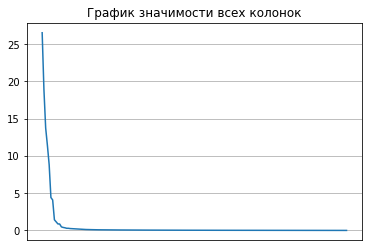

count    175.000000
mean       0.571429
std        2.882083
min        0.000000
25%        0.010801
50%        0.023733
75%        0.059211
max       26.538503
dtype: float64

In [350]:
importances.plot()
plt.grid()
plt.title('График значимости всех колонок')
plt.xticks(ticks=[])
plt.show()
display(importances.describe())

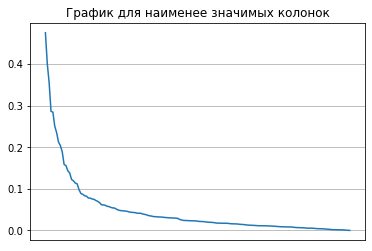

In [351]:
importances[importances < .5].plot()
plt.grid()
plt.title('График для наименее значимых колонок')
plt.xticks(ticks=[])
plt.show();

Из графиков видно, что около трети всех колонок имеют значимость меньше 0.01. Оставляем только колонки значимость которых выше.

In [352]:
features_keep = importances[importances > .01].index.tolist()
len(features_keep), features_keep

(134,
 ['age',
  'engine_power',
  'mileage',
  'model_name',
  'engine_displacement',
  'brand',
  'name',
  'привод',
  'body_type',
  'equipment_dict_rear-seat-heat-vent',
  'fuel_type',
  'equipment_dict_electro-trunk',
  'equipment_dict_led-lights',
  'vendor',
  'equipment_dict_roller-blinds-for-rear-side-windows',
  'owners',
  'equipment_dict_360-camera',
  'equipment_dict_traffic-sign-recognition',
  'equipment_dict_high-beam-assist',
  'number_of_doors',
  'equipment_dict_roof-rails',
  'equipment_dict_lane-keeping-assist',
  'equipment_dict_air-suspension',
  'color',
  'equipment_dict_body-kit',
  'equipment_dict_roller-blind-for-rear-window',
  'equipment_dict_folding-tables-rear',
  'equipment_dict_third-row-seats',
  'vehicle_transmission',
  'equipment_dict_wireless-charger',
  'equipment_dict_drowsy-driver-alert-system',
  'equipment_dict_hatch',
  'equipment_dict_ptf',
  'equipment_dict_entertainment-system-for-rear-seat-passengers',
  'equipment_dict_steering-wheel-g

### Проверка модели только на значимых колонках


In [353]:
# X_train, X_test, y_train, y_test = train_test_split(X.iloc[:200000,:30000], y[:200000], test_size=0.3, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, features_keep], y, test_size=0.3, shuffle=True, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+eff_eq_cols+good_corr_cols[:3]], y, test_size=0.3, shuffle=True, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+eff_eq_cols+good_corr_cols[:0]], y, test_size=0.3, shuffle=True, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+equipment_dict_cols+good_corr_cols], y,
#                                                     test_size=0.3, shuffle=True, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols_to_poly+good_corr_cols[:3]], y, test_size=0.3, shuffle=True, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20867, 134), (8943, 134), (20867,), (8943,))

In [354]:
# model.fit(X.loc[:,cols_to_poly+equipment_dict_cols], y,
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         early_stopping_rounds=30,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4889086	test: 1.5876581	best: 1.5876581 (0)	total: 7.53ms	remaining: 1m 15s
1:	learn: 1.4112629	test: 1.5051899	best: 1.5051899 (1)	total: 26.9ms	remaining: 2m 14s
2:	learn: 1.3421896	test: 1.4320233	best: 1.4320233 (2)	total: 42.9ms	remaining: 2m 22s
3:	learn: 1.2808676	test: 1.3674796	best: 1.3674796 (3)	total: 58.3ms	remaining: 2m 25s
4:	learn: 1.2079267	test: 1.2898217	best: 1.2898217 (4)	total: 66.8ms	remaining: 2m 13s
5:	learn: 1.1468445	test: 1.2249303	best: 1.2249303 (5)	total: 87.3ms	remaining: 2m 25s
6:	learn: 1.0917271	test: 1.1663152	best: 1.1663152 (6)	total: 94.8ms	remaining: 2m 15s
7:	learn: 1.0405099	test: 1.1114982	best: 1.1114982 (7)	total: 119ms	remaining: 2m 28s
8:	learn: 0.9960463	test: 1.0644470	best: 1.0644470 (8)	total: 127ms	remaining: 2m 20s
9:	learn: 0.9541410	test: 1.0202088	best: 1.0202088 (9)	total: 135ms	remaining: 2m 14s
10:	learn: 0.9039343	test: 0.9666956	best: 0.9666956 (10)	total: 143ms	remaining: 2m 9s
11:	learn: 0.8568154	test: 0.916464

105:	learn: 0.2048672	test: 0.2160739	best: 0.2160739 (105)	total: 1.34s	remaining: 2m 5s
106:	learn: 0.2048637	test: 0.2160849	best: 0.2160739 (105)	total: 1.35s	remaining: 2m 5s
107:	learn: 0.2048875	test: 0.2161144	best: 0.2160739 (105)	total: 1.36s	remaining: 2m 4s
108:	learn: 0.2047338	test: 0.2159537	best: 0.2159537 (108)	total: 1.38s	remaining: 2m 4s
109:	learn: 0.2040526	test: 0.2154364	best: 0.2154364 (109)	total: 1.38s	remaining: 2m 4s
110:	learn: 0.2028307	test: 0.2143264	best: 0.2143264 (110)	total: 1.39s	remaining: 2m 3s
111:	learn: 0.2028486	test: 0.2143604	best: 0.2143264 (110)	total: 1.4s	remaining: 2m 3s
112:	learn: 0.2025874	test: 0.2140664	best: 0.2140664 (112)	total: 1.41s	remaining: 2m 3s
113:	learn: 0.2007857	test: 0.2118889	best: 0.2118889 (113)	total: 1.41s	remaining: 2m 2s
114:	learn: 0.2003315	test: 0.2113716	best: 0.2113716 (114)	total: 1.42s	remaining: 2m 2s
115:	learn: 0.1998814	test: 0.2108676	best: 0.2108676 (115)	total: 1.43s	remaining: 2m 1s
116:	learn:

204:	learn: 0.1692869	test: 0.1786686	best: 0.1786686 (204)	total: 2.5s	remaining: 1m 59s
205:	learn: 0.1692337	test: 0.1786097	best: 0.1786097 (205)	total: 2.51s	remaining: 1m 59s
206:	learn: 0.1691705	test: 0.1785398	best: 0.1785398 (206)	total: 2.52s	remaining: 1m 59s
207:	learn: 0.1691690	test: 0.1785821	best: 0.1785398 (206)	total: 2.53s	remaining: 1m 59s
208:	learn: 0.1686875	test: 0.1781920	best: 0.1781920 (208)	total: 2.54s	remaining: 1m 59s
209:	learn: 0.1683459	test: 0.1778811	best: 0.1778811 (209)	total: 2.56s	remaining: 1m 59s
210:	learn: 0.1681604	test: 0.1777229	best: 0.1777229 (210)	total: 2.57s	remaining: 1m 59s
211:	learn: 0.1681676	test: 0.1777381	best: 0.1777229 (210)	total: 2.59s	remaining: 1m 59s
212:	learn: 0.1677451	test: 0.1773172	best: 0.1773172 (212)	total: 2.61s	remaining: 1m 59s
213:	learn: 0.1674145	test: 0.1770062	best: 0.1770062 (213)	total: 2.61s	remaining: 1m 59s
214:	learn: 0.1672817	test: 0.1769045	best: 0.1769045 (214)	total: 2.62s	remaining: 1m 59s


303:	learn: 0.1540523	test: 0.1635782	best: 0.1635782 (303)	total: 3.65s	remaining: 1m 56s
304:	learn: 0.1540298	test: 0.1635776	best: 0.1635776 (304)	total: 3.66s	remaining: 1m 56s
305:	learn: 0.1539358	test: 0.1635221	best: 0.1635221 (305)	total: 3.68s	remaining: 1m 56s
306:	learn: 0.1534485	test: 0.1630376	best: 0.1630376 (306)	total: 3.69s	remaining: 1m 56s
307:	learn: 0.1534283	test: 0.1630207	best: 0.1630207 (307)	total: 3.69s	remaining: 1m 56s
308:	learn: 0.1530056	test: 0.1625759	best: 0.1625759 (308)	total: 3.7s	remaining: 1m 56s
309:	learn: 0.1528290	test: 0.1624699	best: 0.1624699 (309)	total: 3.71s	remaining: 1m 56s
310:	learn: 0.1527795	test: 0.1624106	best: 0.1624106 (310)	total: 3.73s	remaining: 1m 56s
311:	learn: 0.1527378	test: 0.1623584	best: 0.1623584 (311)	total: 3.74s	remaining: 1m 56s
312:	learn: 0.1527191	test: 0.1623516	best: 0.1623516 (312)	total: 3.76s	remaining: 1m 56s
313:	learn: 0.1527339	test: 0.1624008	best: 0.1623516 (312)	total: 3.77s	remaining: 1m 56s


407:	learn: 0.1431645	test: 0.1538022	best: 0.1537043 (405)	total: 5.03s	remaining: 1m 58s
408:	learn: 0.1430646	test: 0.1537673	best: 0.1537043 (405)	total: 5.04s	remaining: 1m 58s
409:	learn: 0.1430488	test: 0.1537612	best: 0.1537043 (405)	total: 5.04s	remaining: 1m 58s
410:	learn: 0.1429621	test: 0.1537337	best: 0.1537043 (405)	total: 5.06s	remaining: 1m 57s
411:	learn: 0.1429453	test: 0.1537693	best: 0.1537043 (405)	total: 5.07s	remaining: 1m 57s
412:	learn: 0.1428753	test: 0.1536869	best: 0.1536869 (412)	total: 5.07s	remaining: 1m 57s
413:	learn: 0.1428507	test: 0.1536765	best: 0.1536765 (413)	total: 5.08s	remaining: 1m 57s
414:	learn: 0.1427987	test: 0.1536293	best: 0.1536293 (414)	total: 5.09s	remaining: 1m 57s
415:	learn: 0.1427757	test: 0.1536400	best: 0.1536293 (414)	total: 5.13s	remaining: 1m 58s
416:	learn: 0.1427394	test: 0.1535926	best: 0.1535926 (416)	total: 5.14s	remaining: 1m 58s
417:	learn: 0.1427030	test: 0.1535558	best: 0.1535558 (417)	total: 5.15s	remaining: 1m 58s

500:	learn: 0.1378053	test: 0.1495965	best: 0.1495965 (500)	total: 6.22s	remaining: 1m 57s
501:	learn: 0.1377348	test: 0.1495414	best: 0.1495414 (501)	total: 6.23s	remaining: 1m 57s
502:	learn: 0.1374941	test: 0.1494406	best: 0.1494406 (502)	total: 6.24s	remaining: 1m 57s
503:	learn: 0.1374541	test: 0.1494064	best: 0.1494064 (503)	total: 6.25s	remaining: 1m 57s
504:	learn: 0.1373994	test: 0.1493977	best: 0.1493977 (504)	total: 6.27s	remaining: 1m 57s
505:	learn: 0.1374065	test: 0.1494267	best: 0.1493977 (504)	total: 6.28s	remaining: 1m 57s
506:	learn: 0.1373893	test: 0.1494663	best: 0.1493977 (504)	total: 6.28s	remaining: 1m 57s
507:	learn: 0.1372385	test: 0.1492655	best: 0.1492655 (507)	total: 6.3s	remaining: 1m 57s
508:	learn: 0.1372088	test: 0.1492355	best: 0.1492355 (508)	total: 6.3s	remaining: 1m 57s
509:	learn: 0.1371748	test: 0.1492217	best: 0.1492217 (509)	total: 6.33s	remaining: 1m 57s
510:	learn: 0.1371629	test: 0.1492089	best: 0.1492089 (510)	total: 6.34s	remaining: 1m 57s
5

591:	learn: 0.1330189	test: 0.1468725	best: 0.1468243 (587)	total: 7.39s	remaining: 1m 57s
592:	learn: 0.1328320	test: 0.1466864	best: 0.1466864 (592)	total: 7.41s	remaining: 1m 57s
593:	learn: 0.1327742	test: 0.1466070	best: 0.1466070 (593)	total: 7.42s	remaining: 1m 57s
594:	learn: 0.1326735	test: 0.1465163	best: 0.1465163 (594)	total: 7.44s	remaining: 1m 57s
595:	learn: 0.1326923	test: 0.1465666	best: 0.1465163 (594)	total: 7.45s	remaining: 1m 57s
596:	learn: 0.1324969	test: 0.1462545	best: 0.1462545 (596)	total: 7.45s	remaining: 1m 57s
597:	learn: 0.1324826	test: 0.1462520	best: 0.1462520 (597)	total: 7.46s	remaining: 1m 57s
598:	learn: 0.1323947	test: 0.1462008	best: 0.1462008 (598)	total: 7.47s	remaining: 1m 57s
599:	learn: 0.1323972	test: 0.1462273	best: 0.1462008 (598)	total: 7.48s	remaining: 1m 57s
600:	learn: 0.1323860	test: 0.1462266	best: 0.1462008 (598)	total: 7.49s	remaining: 1m 57s
601:	learn: 0.1323271	test: 0.1461756	best: 0.1461756 (601)	total: 7.5s	remaining: 1m 57s


699:	learn: 0.1285421	test: 0.1436927	best: 0.1436927 (699)	total: 8.8s	remaining: 1m 56s
700:	learn: 0.1284305	test: 0.1435703	best: 0.1435703 (700)	total: 8.82s	remaining: 1m 56s
701:	learn: 0.1283742	test: 0.1435085	best: 0.1435085 (701)	total: 8.84s	remaining: 1m 57s
702:	learn: 0.1283691	test: 0.1435427	best: 0.1435085 (701)	total: 8.87s	remaining: 1m 57s
703:	learn: 0.1283033	test: 0.1434772	best: 0.1434772 (703)	total: 8.9s	remaining: 1m 57s
704:	learn: 0.1282625	test: 0.1434523	best: 0.1434523 (704)	total: 8.93s	remaining: 1m 57s
705:	learn: 0.1282180	test: 0.1434018	best: 0.1434018 (705)	total: 8.94s	remaining: 1m 57s
706:	learn: 0.1281941	test: 0.1433900	best: 0.1433900 (706)	total: 8.96s	remaining: 1m 57s
707:	learn: 0.1281852	test: 0.1434003	best: 0.1433900 (706)	total: 8.97s	remaining: 1m 57s
708:	learn: 0.1281248	test: 0.1433641	best: 0.1433641 (708)	total: 8.99s	remaining: 1m 57s
709:	learn: 0.1281093	test: 0.1433440	best: 0.1433440 (709)	total: 9s	remaining: 1m 57s
710:

795:	learn: 0.1250899	test: 0.1415079	best: 0.1415079 (795)	total: 10.2s	remaining: 1m 57s
796:	learn: 0.1250528	test: 0.1414689	best: 0.1414689 (796)	total: 10.2s	remaining: 1m 57s
797:	learn: 0.1250176	test: 0.1415302	best: 0.1414689 (796)	total: 10.2s	remaining: 1m 57s
798:	learn: 0.1249919	test: 0.1415318	best: 0.1414689 (796)	total: 10.2s	remaining: 1m 57s
799:	learn: 0.1249099	test: 0.1414765	best: 0.1414689 (796)	total: 10.2s	remaining: 1m 57s
800:	learn: 0.1249017	test: 0.1414917	best: 0.1414689 (796)	total: 10.2s	remaining: 1m 57s
801:	learn: 0.1249124	test: 0.1415068	best: 0.1414689 (796)	total: 10.3s	remaining: 1m 57s
802:	learn: 0.1248995	test: 0.1415270	best: 0.1414689 (796)	total: 10.3s	remaining: 1m 57s
803:	learn: 0.1248192	test: 0.1414225	best: 0.1414225 (803)	total: 10.3s	remaining: 1m 57s
804:	learn: 0.1247860	test: 0.1413902	best: 0.1413902 (804)	total: 10.3s	remaining: 1m 57s
805:	learn: 0.1247386	test: 0.1413407	best: 0.1413407 (805)	total: 10.3s	remaining: 1m 57s

895:	learn: 0.1219944	test: 0.1401273	best: 0.1401265 (893)	total: 11.5s	remaining: 1m 57s
896:	learn: 0.1219571	test: 0.1401045	best: 0.1401045 (896)	total: 11.5s	remaining: 1m 57s
897:	learn: 0.1219501	test: 0.1400892	best: 0.1400892 (897)	total: 11.6s	remaining: 1m 57s
898:	learn: 0.1219161	test: 0.1400562	best: 0.1400562 (898)	total: 11.6s	remaining: 1m 57s
899:	learn: 0.1218793	test: 0.1400364	best: 0.1400364 (899)	total: 11.6s	remaining: 1m 57s
900:	learn: 0.1218616	test: 0.1400088	best: 0.1400088 (900)	total: 11.6s	remaining: 1m 57s
901:	learn: 0.1218296	test: 0.1399856	best: 0.1399856 (901)	total: 11.6s	remaining: 1m 57s
902:	learn: 0.1218077	test: 0.1399894	best: 0.1399856 (901)	total: 11.6s	remaining: 1m 57s
903:	learn: 0.1218065	test: 0.1399938	best: 0.1399856 (901)	total: 11.6s	remaining: 1m 57s
904:	learn: 0.1217613	test: 0.1399525	best: 0.1399525 (904)	total: 11.7s	remaining: 1m 57s
905:	learn: 0.1217437	test: 0.1399560	best: 0.1399525 (904)	total: 11.7s	remaining: 1m 57s

1000:	learn: 0.1193857	test: 0.1388257	best: 0.1386578 (985)	total: 12.9s	remaining: 1m 55s
1001:	learn: 0.1193627	test: 0.1388122	best: 0.1386578 (985)	total: 12.9s	remaining: 1m 55s
1002:	learn: 0.1192810	test: 0.1387775	best: 0.1386578 (985)	total: 12.9s	remaining: 1m 55s
1003:	learn: 0.1192832	test: 0.1387964	best: 0.1386578 (985)	total: 12.9s	remaining: 1m 55s
1004:	learn: 0.1192440	test: 0.1387917	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
1005:	learn: 0.1192076	test: 0.1387746	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
1006:	learn: 0.1191672	test: 0.1387661	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
1007:	learn: 0.1191697	test: 0.1387775	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
1008:	learn: 0.1191461	test: 0.1387655	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
1009:	learn: 0.1190571	test: 0.1386787	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
1010:	learn: 0.1190269	test: 0.1386748	best: 0.1386578 (985)	total: 13s	remaining: 1m 55s
10

1097:	learn: 0.1170670	test: 0.1378808	best: 0.1378808 (1097)	total: 14.3s	remaining: 1m 55s
1098:	learn: 0.1170609	test: 0.1378909	best: 0.1378808 (1097)	total: 14.3s	remaining: 1m 55s
1099:	learn: 0.1170589	test: 0.1378954	best: 0.1378808 (1097)	total: 14.3s	remaining: 1m 55s
1100:	learn: 0.1169920	test: 0.1378430	best: 0.1378430 (1100)	total: 14.3s	remaining: 1m 55s
1101:	learn: 0.1169552	test: 0.1378068	best: 0.1378068 (1101)	total: 14.3s	remaining: 1m 55s
1102:	learn: 0.1169383	test: 0.1378046	best: 0.1378046 (1102)	total: 14.3s	remaining: 1m 55s
1103:	learn: 0.1169275	test: 0.1378079	best: 0.1378046 (1102)	total: 14.4s	remaining: 1m 55s
1104:	learn: 0.1169019	test: 0.1378016	best: 0.1378016 (1104)	total: 14.4s	remaining: 1m 55s
1105:	learn: 0.1168860	test: 0.1377907	best: 0.1377907 (1105)	total: 14.4s	remaining: 1m 55s
1106:	learn: 0.1168572	test: 0.1377615	best: 0.1377615 (1106)	total: 14.4s	remaining: 1m 55s
1107:	learn: 0.1168485	test: 0.1377738	best: 0.1377615 (1106)	total: 1

1192:	learn: 0.1151765	test: 0.1372131	best: 0.1372131 (1192)	total: 15.5s	remaining: 1m 54s
1193:	learn: 0.1150953	test: 0.1371116	best: 0.1371116 (1193)	total: 15.5s	remaining: 1m 54s
1194:	learn: 0.1150856	test: 0.1371123	best: 0.1371116 (1193)	total: 15.5s	remaining: 1m 54s
1195:	learn: 0.1150350	test: 0.1370955	best: 0.1370955 (1195)	total: 15.5s	remaining: 1m 54s
1196:	learn: 0.1150394	test: 0.1371069	best: 0.1370955 (1195)	total: 15.5s	remaining: 1m 54s
1197:	learn: 0.1150294	test: 0.1371046	best: 0.1370955 (1195)	total: 15.5s	remaining: 1m 54s
1198:	learn: 0.1150137	test: 0.1371010	best: 0.1370955 (1195)	total: 15.5s	remaining: 1m 54s
1199:	learn: 0.1150125	test: 0.1371076	best: 0.1370955 (1195)	total: 15.5s	remaining: 1m 54s
1200:	learn: 0.1149973	test: 0.1371034	best: 0.1370955 (1195)	total: 15.6s	remaining: 1m 53s
1201:	learn: 0.1149105	test: 0.1370495	best: 0.1370495 (1201)	total: 15.6s	remaining: 1m 53s
1202:	learn: 0.1148237	test: 0.1369395	best: 0.1369395 (1202)	total: 1

1281:	learn: 0.1131817	test: 0.1363359	best: 0.1362889 (1279)	total: 16.5s	remaining: 1m 52s
1282:	learn: 0.1131734	test: 0.1363248	best: 0.1362889 (1279)	total: 16.5s	remaining: 1m 52s
1283:	learn: 0.1131620	test: 0.1363075	best: 0.1362889 (1279)	total: 16.5s	remaining: 1m 51s
1284:	learn: 0.1131474	test: 0.1362991	best: 0.1362889 (1279)	total: 16.5s	remaining: 1m 51s
1285:	learn: 0.1131120	test: 0.1362843	best: 0.1362843 (1285)	total: 16.5s	remaining: 1m 51s
1286:	learn: 0.1131069	test: 0.1362995	best: 0.1362843 (1285)	total: 16.5s	remaining: 1m 51s
1287:	learn: 0.1131115	test: 0.1363644	best: 0.1362843 (1285)	total: 16.5s	remaining: 1m 51s
1288:	learn: 0.1130675	test: 0.1363428	best: 0.1362843 (1285)	total: 16.6s	remaining: 1m 51s
1289:	learn: 0.1130523	test: 0.1363357	best: 0.1362843 (1285)	total: 16.6s	remaining: 1m 51s
1290:	learn: 0.1130372	test: 0.1363310	best: 0.1362843 (1285)	total: 16.6s	remaining: 1m 51s
1291:	learn: 0.1130323	test: 0.1363228	best: 0.1362843 (1285)	total: 1

1382:	learn: 0.1110087	test: 0.1354166	best: 0.1353993 (1379)	total: 17.8s	remaining: 1m 51s
1383:	learn: 0.1109730	test: 0.1354003	best: 0.1353993 (1379)	total: 17.8s	remaining: 1m 51s
1384:	learn: 0.1109285	test: 0.1354195	best: 0.1353993 (1379)	total: 17.9s	remaining: 1m 51s
1385:	learn: 0.1109207	test: 0.1354284	best: 0.1353993 (1379)	total: 17.9s	remaining: 1m 51s
1386:	learn: 0.1109044	test: 0.1354223	best: 0.1353993 (1379)	total: 17.9s	remaining: 1m 50s
1387:	learn: 0.1109061	test: 0.1354396	best: 0.1353993 (1379)	total: 17.9s	remaining: 1m 50s
1388:	learn: 0.1109025	test: 0.1354493	best: 0.1353993 (1379)	total: 17.9s	remaining: 1m 50s
1389:	learn: 0.1108229	test: 0.1353964	best: 0.1353964 (1389)	total: 17.9s	remaining: 1m 50s
1390:	learn: 0.1107944	test: 0.1353737	best: 0.1353737 (1390)	total: 17.9s	remaining: 1m 50s
1391:	learn: 0.1107877	test: 0.1353793	best: 0.1353737 (1390)	total: 17.9s	remaining: 1m 50s
1392:	learn: 0.1107388	test: 0.1353376	best: 0.1353376 (1392)	total: 1

1481:	learn: 0.1091905	test: 0.1348750	best: 0.1348492 (1478)	total: 19s	remaining: 1m 49s
1482:	learn: 0.1091709	test: 0.1348597	best: 0.1348492 (1478)	total: 19s	remaining: 1m 49s
1483:	learn: 0.1091129	test: 0.1348563	best: 0.1348492 (1478)	total: 19.1s	remaining: 1m 49s
1484:	learn: 0.1090725	test: 0.1348059	best: 0.1348059 (1484)	total: 19.1s	remaining: 1m 49s
1485:	learn: 0.1090541	test: 0.1347870	best: 0.1347870 (1485)	total: 19.1s	remaining: 1m 49s
1486:	learn: 0.1090458	test: 0.1347846	best: 0.1347846 (1486)	total: 19.2s	remaining: 1m 49s
1487:	learn: 0.1090178	test: 0.1348238	best: 0.1347846 (1486)	total: 19.2s	remaining: 1m 49s
1488:	learn: 0.1090055	test: 0.1348256	best: 0.1347846 (1486)	total: 19.2s	remaining: 1m 49s
1489:	learn: 0.1089931	test: 0.1348190	best: 0.1347846 (1486)	total: 19.2s	remaining: 1m 49s
1490:	learn: 0.1089941	test: 0.1348440	best: 0.1347846 (1486)	total: 19.2s	remaining: 1m 49s
1491:	learn: 0.1089782	test: 0.1348530	best: 0.1347846 (1486)	total: 19.2s

1580:	learn: 0.1073606	test: 0.1342980	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1581:	learn: 0.1073451	test: 0.1342951	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1582:	learn: 0.1073448	test: 0.1343021	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1583:	learn: 0.1073415	test: 0.1343161	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1584:	learn: 0.1073244	test: 0.1343057	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1585:	learn: 0.1073165	test: 0.1343087	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1586:	learn: 0.1072824	test: 0.1342845	best: 0.1342576 (1575)	total: 20.4s	remaining: 1m 48s
1587:	learn: 0.1072827	test: 0.1342926	best: 0.1342576 (1575)	total: 20.5s	remaining: 1m 48s
1588:	learn: 0.1072662	test: 0.1342916	best: 0.1342576 (1575)	total: 20.5s	remaining: 1m 48s
1589:	learn: 0.1072516	test: 0.1342805	best: 0.1342576 (1575)	total: 20.5s	remaining: 1m 48s
1590:	learn: 0.1072502	test: 0.1342893	best: 0.1342576 (1575)	total: 2

В результате уменьшения числа колонок получено повышение точности предсказания до 0.134.

## Обучаем на полном датасете

Ограничиваем число деревьев полученными 1600, на большем наборе данных переобучение должно еще снизиться.

In [366]:
model = CatBoostRegressor(iterations=1600, learning_rate=0.072,
                          eval_metric='MAPE', custom_metric=['R2', 'MAE'],
                          random_seed = 42, #metric_period=10, 
#                           silent=True,
                         )
model.fit(X[features_keep], y, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5239008	total: 8.32ms	remaining: 13.3s
1:	learn: 1.4440692	total: 17.9ms	remaining: 14.3s
2:	learn: 1.3766013	total: 26.5ms	remaining: 14.1s
3:	learn: 1.3198497	total: 38.1ms	remaining: 15.2s
4:	learn: 1.2439350	total: 49.5ms	remaining: 15.8s
5:	learn: 1.1816537	total: 87.4ms	remaining: 23.2s
6:	learn: 1.1202150	total: 117ms	remaining: 26.6s
7:	learn: 1.0693436	total: 131ms	remaining: 26s
8:	learn: 1.0228625	total: 145ms	remaining: 25.7s
9:	learn: 0.9761453	total: 161ms	remaining: 25.6s
10:	learn: 0.9367449	total: 170ms	remaining: 24.5s
11:	learn: 0.8882594	total: 191ms	remaining: 25.3s
12:	learn: 0.8548262	total: 200ms	remaining: 24.5s
13:	learn: 0.8195850	total: 237ms	remaining: 26.8s
14:	learn: 0.7862108	total: 246ms	remaining: 25.9s
15:	learn: 0.7525866	total: 268ms	remaining: 26.6s
16:	learn: 0.7175774	total: 277ms	remaining: 25.8s
17:	learn: 0.6808294	total: 286ms	remaining: 25.2s
18:	learn: 0.6590085	total: 298ms	remaining: 24.8s
19:	learn: 0.6304312	total: 306ms	rem

165:	learn: 0.1811836	total: 2.17s	remaining: 18.7s
166:	learn: 0.1801282	total: 2.18s	remaining: 18.7s
167:	learn: 0.1798447	total: 2.2s	remaining: 18.7s
168:	learn: 0.1796399	total: 2.21s	remaining: 18.7s
169:	learn: 0.1794433	total: 2.23s	remaining: 18.7s
170:	learn: 0.1790681	total: 2.24s	remaining: 18.7s
171:	learn: 0.1779733	total: 2.26s	remaining: 18.8s
172:	learn: 0.1777651	total: 2.27s	remaining: 18.7s
173:	learn: 0.1776516	total: 2.29s	remaining: 18.8s
174:	learn: 0.1777086	total: 2.3s	remaining: 18.7s
175:	learn: 0.1773703	total: 2.34s	remaining: 18.9s
176:	learn: 0.1772869	total: 2.35s	remaining: 18.9s
177:	learn: 0.1771234	total: 2.37s	remaining: 18.9s
178:	learn: 0.1769124	total: 2.39s	remaining: 18.9s
179:	learn: 0.1767066	total: 2.4s	remaining: 18.9s
180:	learn: 0.1766914	total: 2.41s	remaining: 18.9s
181:	learn: 0.1760657	total: 2.42s	remaining: 18.9s
182:	learn: 0.1757027	total: 2.44s	remaining: 18.9s
183:	learn: 0.1752359	total: 2.44s	remaining: 18.8s
184:	learn: 0.1

327:	learn: 0.1548271	total: 4.54s	remaining: 17.6s
328:	learn: 0.1546612	total: 4.55s	remaining: 17.6s
329:	learn: 0.1546180	total: 4.56s	remaining: 17.6s
330:	learn: 0.1545749	total: 4.57s	remaining: 17.5s
331:	learn: 0.1545266	total: 4.61s	remaining: 17.6s
332:	learn: 0.1542042	total: 4.62s	remaining: 17.6s
333:	learn: 0.1541080	total: 4.63s	remaining: 17.6s
334:	learn: 0.1541964	total: 4.66s	remaining: 17.6s
335:	learn: 0.1541383	total: 4.66s	remaining: 17.5s
336:	learn: 0.1540769	total: 4.67s	remaining: 17.5s
337:	learn: 0.1538093	total: 4.68s	remaining: 17.5s
338:	learn: 0.1537575	total: 4.69s	remaining: 17.5s
339:	learn: 0.1537230	total: 4.73s	remaining: 17.5s
340:	learn: 0.1536699	total: 4.76s	remaining: 17.6s
341:	learn: 0.1536859	total: 4.77s	remaining: 17.5s
342:	learn: 0.1535030	total: 4.78s	remaining: 17.5s
343:	learn: 0.1534557	total: 4.79s	remaining: 17.5s
344:	learn: 0.1533936	total: 4.8s	remaining: 17.5s
345:	learn: 0.1533691	total: 4.82s	remaining: 17.5s
346:	learn: 0

486:	learn: 0.1416629	total: 6.98s	remaining: 16s
487:	learn: 0.1416583	total: 7s	remaining: 15.9s
488:	learn: 0.1416225	total: 7s	remaining: 15.9s
489:	learn: 0.1416020	total: 7.03s	remaining: 15.9s
490:	learn: 0.1415942	total: 7.04s	remaining: 15.9s
491:	learn: 0.1415758	total: 7.07s	remaining: 15.9s
492:	learn: 0.1415086	total: 7.09s	remaining: 15.9s
493:	learn: 0.1414307	total: 7.09s	remaining: 15.9s
494:	learn: 0.1414357	total: 7.11s	remaining: 15.9s
495:	learn: 0.1414338	total: 7.12s	remaining: 15.8s
496:	learn: 0.1414120	total: 7.13s	remaining: 15.8s
497:	learn: 0.1412920	total: 7.14s	remaining: 15.8s
498:	learn: 0.1411692	total: 7.15s	remaining: 15.8s
499:	learn: 0.1411225	total: 7.16s	remaining: 15.8s
500:	learn: 0.1411085	total: 7.17s	remaining: 15.7s
501:	learn: 0.1411044	total: 7.19s	remaining: 15.7s
502:	learn: 0.1410026	total: 7.2s	remaining: 15.7s
503:	learn: 0.1409810	total: 7.21s	remaining: 15.7s
504:	learn: 0.1409604	total: 7.22s	remaining: 15.7s
505:	learn: 0.1409648

651:	learn: 0.1339875	total: 9.13s	remaining: 13.3s
652:	learn: 0.1339897	total: 9.14s	remaining: 13.3s
653:	learn: 0.1339236	total: 9.15s	remaining: 13.2s
654:	learn: 0.1339366	total: 9.16s	remaining: 13.2s
655:	learn: 0.1338906	total: 9.17s	remaining: 13.2s
656:	learn: 0.1337961	total: 9.2s	remaining: 13.2s
657:	learn: 0.1337961	total: 9.21s	remaining: 13.2s
658:	learn: 0.1336624	total: 9.22s	remaining: 13.2s
659:	learn: 0.1336490	total: 9.22s	remaining: 13.1s
660:	learn: 0.1336246	total: 9.24s	remaining: 13.1s
661:	learn: 0.1336005	total: 9.26s	remaining: 13.1s
662:	learn: 0.1335209	total: 9.26s	remaining: 13.1s
663:	learn: 0.1334814	total: 9.27s	remaining: 13.1s
664:	learn: 0.1334672	total: 9.28s	remaining: 13.1s
665:	learn: 0.1333923	total: 9.3s	remaining: 13s
666:	learn: 0.1333994	total: 9.31s	remaining: 13s
667:	learn: 0.1333908	total: 9.33s	remaining: 13s
668:	learn: 0.1333690	total: 9.35s	remaining: 13s
669:	learn: 0.1332326	total: 9.37s	remaining: 13s
670:	learn: 0.1331338	to

816:	learn: 0.1287833	total: 11.5s	remaining: 11s
817:	learn: 0.1287576	total: 11.5s	remaining: 11s
818:	learn: 0.1286976	total: 11.5s	remaining: 11s
819:	learn: 0.1287076	total: 11.5s	remaining: 11s
820:	learn: 0.1286497	total: 11.6s	remaining: 11s
821:	learn: 0.1285652	total: 11.6s	remaining: 11s
822:	learn: 0.1285547	total: 11.6s	remaining: 10.9s
823:	learn: 0.1283742	total: 11.6s	remaining: 10.9s
824:	learn: 0.1283589	total: 11.6s	remaining: 10.9s
825:	learn: 0.1282916	total: 11.6s	remaining: 10.9s
826:	learn: 0.1282542	total: 11.6s	remaining: 10.9s
827:	learn: 0.1282541	total: 11.7s	remaining: 10.9s
828:	learn: 0.1282653	total: 11.7s	remaining: 10.9s
829:	learn: 0.1282485	total: 11.7s	remaining: 10.8s
830:	learn: 0.1281109	total: 11.7s	remaining: 10.8s
831:	learn: 0.1279566	total: 11.7s	remaining: 10.8s
832:	learn: 0.1279726	total: 11.7s	remaining: 10.8s
833:	learn: 0.1279565	total: 11.8s	remaining: 10.8s
834:	learn: 0.1279740	total: 11.8s	remaining: 10.8s
835:	learn: 0.1279515	to

986:	learn: 0.1242848	total: 13.9s	remaining: 8.63s
987:	learn: 0.1242796	total: 13.9s	remaining: 8.62s
988:	learn: 0.1242827	total: 13.9s	remaining: 8.61s
989:	learn: 0.1242405	total: 13.9s	remaining: 8.59s
990:	learn: 0.1242210	total: 13.9s	remaining: 8.57s
991:	learn: 0.1242103	total: 14s	remaining: 8.55s
992:	learn: 0.1241616	total: 14s	remaining: 8.54s
993:	learn: 0.1241497	total: 14s	remaining: 8.53s
994:	learn: 0.1241380	total: 14s	remaining: 8.51s
995:	learn: 0.1241188	total: 14s	remaining: 8.5s
996:	learn: 0.1241197	total: 14s	remaining: 8.49s
997:	learn: 0.1241103	total: 14s	remaining: 8.47s
998:	learn: 0.1240683	total: 14.1s	remaining: 8.46s
999:	learn: 0.1240489	total: 14.1s	remaining: 8.44s
1000:	learn: 0.1240230	total: 14.1s	remaining: 8.43s
1001:	learn: 0.1240080	total: 14.1s	remaining: 8.42s
1002:	learn: 0.1239809	total: 14.1s	remaining: 8.4s
1003:	learn: 0.1239742	total: 14.1s	remaining: 8.39s
1004:	learn: 0.1239532	total: 14.1s	remaining: 8.37s
1005:	learn: 0.1239570	

1144:	learn: 0.1207886	total: 16.2s	remaining: 6.45s
1145:	learn: 0.1207727	total: 16.2s	remaining: 6.43s
1146:	learn: 0.1207466	total: 16.3s	remaining: 6.42s
1147:	learn: 0.1207201	total: 16.3s	remaining: 6.41s
1148:	learn: 0.1207178	total: 16.3s	remaining: 6.4s
1149:	learn: 0.1207199	total: 16.3s	remaining: 6.38s
1150:	learn: 0.1207132	total: 16.3s	remaining: 6.37s
1151:	learn: 0.1206980	total: 16.3s	remaining: 6.36s
1152:	learn: 0.1206177	total: 16.4s	remaining: 6.34s
1153:	learn: 0.1206079	total: 16.4s	remaining: 6.33s
1154:	learn: 0.1205905	total: 16.4s	remaining: 6.31s
1155:	learn: 0.1205710	total: 16.4s	remaining: 6.3s
1156:	learn: 0.1205570	total: 16.4s	remaining: 6.29s
1157:	learn: 0.1205045	total: 16.4s	remaining: 6.27s
1158:	learn: 0.1204888	total: 16.5s	remaining: 6.26s
1159:	learn: 0.1204781	total: 16.5s	remaining: 6.25s
1160:	learn: 0.1204343	total: 16.5s	remaining: 6.23s
1161:	learn: 0.1204121	total: 16.5s	remaining: 6.22s
1162:	learn: 0.1204195	total: 16.5s	remaining: 6

1312:	learn: 0.1178128	total: 18.8s	remaining: 4.11s
1313:	learn: 0.1178065	total: 18.8s	remaining: 4.1s
1314:	learn: 0.1178088	total: 18.8s	remaining: 4.08s
1315:	learn: 0.1177945	total: 18.8s	remaining: 4.07s
1316:	learn: 0.1177969	total: 18.8s	remaining: 4.05s
1317:	learn: 0.1177743	total: 18.9s	remaining: 4.03s
1318:	learn: 0.1177544	total: 18.9s	remaining: 4.02s
1319:	learn: 0.1177409	total: 18.9s	remaining: 4s
1320:	learn: 0.1176815	total: 18.9s	remaining: 3.99s
1321:	learn: 0.1176730	total: 18.9s	remaining: 3.98s
1322:	learn: 0.1176622	total: 18.9s	remaining: 3.96s
1323:	learn: 0.1176641	total: 19s	remaining: 3.95s
1324:	learn: 0.1176625	total: 19s	remaining: 3.94s
1325:	learn: 0.1176413	total: 19s	remaining: 3.92s
1326:	learn: 0.1176273	total: 19s	remaining: 3.91s
1327:	learn: 0.1175834	total: 19s	remaining: 3.89s
1328:	learn: 0.1175761	total: 19s	remaining: 3.88s
1329:	learn: 0.1175698	total: 19s	remaining: 3.86s
1330:	learn: 0.1175694	total: 19.1s	remaining: 3.85s
1331:	learn

1470:	learn: 0.1153244	total: 21.2s	remaining: 1.85s
1471:	learn: 0.1153061	total: 21.2s	remaining: 1.84s
1472:	learn: 0.1153056	total: 21.2s	remaining: 1.83s
1473:	learn: 0.1152988	total: 21.2s	remaining: 1.81s
1474:	learn: 0.1152843	total: 21.2s	remaining: 1.8s
1475:	learn: 0.1152628	total: 21.2s	remaining: 1.78s
1476:	learn: 0.1152706	total: 21.2s	remaining: 1.77s
1477:	learn: 0.1152660	total: 21.3s	remaining: 1.75s
1478:	learn: 0.1152480	total: 21.3s	remaining: 1.74s
1479:	learn: 0.1152311	total: 21.3s	remaining: 1.73s
1480:	learn: 0.1152239	total: 21.3s	remaining: 1.71s
1481:	learn: 0.1152177	total: 21.3s	remaining: 1.7s
1482:	learn: 0.1152168	total: 21.3s	remaining: 1.68s
1483:	learn: 0.1152155	total: 21.3s	remaining: 1.67s
1484:	learn: 0.1152043	total: 21.3s	remaining: 1.65s
1485:	learn: 0.1151944	total: 21.3s	remaining: 1.64s
1486:	learn: 0.1151704	total: 21.4s	remaining: 1.62s
1487:	learn: 0.1151652	total: 21.4s	remaining: 1.61s
1488:	learn: 0.1151593	total: 21.4s	remaining: 1

In [367]:
predict_result = model.predict(all_coll_df.loc[all_coll_df['sample'] == 0, features_keep])

## Коррекция цены с учетом времени и вывод результатов

Источник данных о ценах - https://www.autostat.ru/infographics/48987/

Аналитики за текущий год еще нет, но можно предположить ускоренный рост цен в связи с политической напряженностью. С учетом срока чуть больше полугода, но с обычным скачком цен в начале года, коэффициент пропорции выберем 0,85.

Сначала попробуем использовать данные об общем повышении цен, уточнив коэффициент инфляции, а потом посмотрим, можно ли улучшить результат с учетом разбивки по возрасту машин - до и после 7 лет.

In [368]:
test = pd.read_csv('test.csv')

def make_sub(res, fname='subm_project_6.csv'):
    test['price'] = res
    test[['sell_id', 'price']].to_csv(fname, index=False)

In [369]:
price_20_all = 136  # % 2014
price_21_all = 165
price_22_all = price_21_all + (price_21_all - price_20_all) * .85
k_all = price_22_all / price_20_all
price_22_all, k_all

(189.65, 1.394485294117647)

In [370]:
# for k in np.arange(1.38,1.42,.01):
# for k in np.arange(1.59,1.616,.004):
for k in (1.603, 1.604, 1.605,):
    res = predict_result / k
    fname = 'subm_project_6_' + str(round(k, 3)).replace('.', '_') + '.csv'
    print(fname)
    make_sub(res, fname)

subm_project_6_1_603.csv
subm_project_6_1_604.csv
subm_project_6_1_605.csv


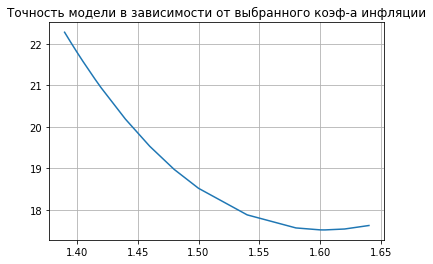

In [371]:
res = pd.DataFrame([
    [1.602,17.51280],[1.601,17.51310],[1.603,17.51266],[1.604,17.51267],
    [1.58,17.56057],[1.6,17.51356],[1.62,17.53461],
    [1.64,17.61902],[1.54,17.87493],[1.5,18.51588],[1.48,18.97138],
    [1.46,19.52690],[1.44,20.18177],[1.42,20.93956],[1.415,21.14584],[1.405,21.57829],[1.4,21.80412],[1.395,22.03687],
    [1.39,22.27628],
    ], columns=['k','score']).sort_values('k')

plt.plot(res.k, res.score)
plt.title('Точность модели в зависимости от выбранного коэф-а инфляции')
plt.grid();

Результаты показали, что рост цен оказался намного выше предполагаемого, и для наших датасетов составляет 1.603.

Исходя из аналитического отчета с указанного сайта невозможно определить, какая доля новых старых машин была в выборке, и она, вероятно, сильно отличается от нашей. Будем предполагать, что рост цен на машины до 7 лет был в 1.8 раза (это значение можно будет уточнить).


In [372]:
all_cars_22 = len(all_coll_df[all_coll_df['sample'] == 1])
all_cars_20 = len(all_coll_df[all_coll_df['sample'] == 0])
all_cars_22_to_7 = len(all_coll_df[(all_coll_df['sample'] == 1) & (all_coll_df['age'] <= 7)])
all_cars_20_to_7 = len(all_coll_df[(all_coll_df['sample'] == 0) & (all_coll_df['age'] <= 7)])
all_cars_22, all_cars_20, all_cars_22_to_7, all_cars_20_to_7

(29810, 34686, 13052, 12589)

In [373]:
price_22_mean = all_coll_df.loc[all_coll_df['sample'] == 1, 'price'].mean()
price_22_to7_mean = all_coll_df.loc[(all_coll_df['sample'] == 1) & (all_coll_df['age'] <= 7), 'price'].mean()
price_22_other_mean = all_coll_df.loc[(all_coll_df['sample'] == 1) & (all_coll_df['age'] > 7), 'price'].mean()

price_22_mean, price_22_to7_mean, price_22_other_mean

(1955507.490909091, 3106569.5930125653, 1059000.5952977682)

In [374]:
k_all = 1.603

def calc_koef(k_to_7=1.8):
    '''
    ko = Co*(na-n7) / (na*Ca / ka - n7*C7 / k7)
    где Ca, C7, Co -- средние цены в 2022 по всем, до 7 лет и остальных
        na, n7 - кол-во машин всех и до 7 лет в 2020
        ka, k7 - коэффициенты удорожания, которые мы задали
        ko - искомый коэф. удорожания более старых машин
    
    '''

    k_other = price_22_other_mean * (all_cars_20 - all_cars_20_to_7) / (
        all_cars_20 * price_22_mean / k_all -
        all_cars_20_to_7 * price_22_to7_mean / k_to_7)

    return k_other

k_to_7 = 1.8
k_other = calc_koef(k_to_7)
k_to_7, k_other, k_to_7 / k_other

(1.8, 1.1366965089341965, 1.5835361381445066)

In [376]:
# for k in np.arange(1.59,1.616,.004):
for k_to_7 in np.arange(1.6, 2.01, .1):
    k_other = calc_koef(k_to_7)
    index_7 = all_coll_df[(all_coll_df['sample'] == 0) & (all_coll_df['age'] <= 7)].index
    res = predict_result / k_other
    res[index_7] = predict_result[index_7] / k_to_7
    fname = 'subm_project_6_k7_' + str(round(k_to_7, 3)).replace(
        '.', '_') + '.csv'
    print(fname)
    make_sub(res, fname)

subm_project_6_k7_1_6.csv
subm_project_6_k7_1_7.csv
subm_project_6_k7_1_8.csv
subm_project_6_k7_1_9.csv
subm_project_6_k7_2_0.csv


## Выводы

1. Выполнена задача по разработке модели предсказания цен на автомобили. 
2. Тренировочный датасет собран с сайта avto.ru и подготовлен полностью самостоятельно. Готовые датасеты не использовались.
3. В ходе работы над проектом возникало большое количество трудностей и неожиданностей. Начиная с защиты сайта от парсинга и заканчивая обработкой данных. Была произведена большая работа над описанием машин, которая не принесла ожидаемого улучшения предсказания модели. 
4. Была учтена разница цен с момента сбора устаревшего тестового датасета и подобраны наилучшие коэффициенты. Это можно сделать более точно, построив отдельную модель с использованием какого-то датасета, совпадающего по времени с тестовым. Но такая работа уже явно за рамками данного проекта.
5. Для итогового предсказания использовался общий коеффициент для всех автомобилей без разделения на до и после 7 лет, т.к. он давал наилучший результат.
6. Итоговый результат модели на соревновании 0.17 по критерию MAPE.